In [62]:
import fermat as F
import numpy as np
import scipy.sparse as sp
import time
from scipy.spatial import  distance_matrix
from sklearn.manifold import TSNE
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from scipy.optimize import LinearConstraint
from scipy.sparse import csr_matrix


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

importe lo necesario y armo las funciones que me dicen el costo de transportar una serie de puntos con fermat dada la matriz de distancias de fermat (lo que usaba en transporte optimo antes), tambien hago su gradiente y pruebo

In [63]:
#Builds fermat graph given data, alpha, method (and if 'D' is chosen with k_fermat neighbours)
#RETURNS: fermat distance matrix between points of data and a KD-Tree 


def fermat_graph(data,alpha,method='FW',k_fermat=30):
    model=F.Fermat(alpha, path_method=method,k=k_fermat)
    model.fit(np.matrix(distance_matrix(data,data)))
    fermat_distances = model.get_distances()
    tree = KDTree(data, leaf_size=2)
    return fermat_distances,tree
              

#Computes fermat_cost of transporting initialData to x with the given fermat_distances
#initial data will be points

#It uses the KD-Tree built with fermat_graph() as well as a parameter 'k' which is 
#the amount of neighbours to look at when getting the fermat distance for a point that
#is not in the graph (including it may be computationally expensive)
#It also recieves the original data and the alpha used to build fermat_distances
              
#RETURNS: fermat cost and gradient of that cost
def fermat_cost(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        dist,grad_idx=fermat_dist(initialData[i,:],real_x[i,:],fermat_distances,tree,k,alpha) 
        q=data[grad_idx,:] 
        local_grad=alpha*(np.linalg.norm(q-real_x[i,:])**(alpha-2))*(real_x[i,:]-q)
        
        res+=dist                      
        gradient[dimension*i:dimension*(i+1)]=local_grad
    return res,2*res*gradient
#TODO ojoo cambie para la DISTANCIA AL CUADRADO!!

#Computes fermat distance between start  and end using fermat_distances
              
#it also recieves the KD-tree, numbre of neighbours to look at, and alpha used in fermat
              
#RETURNS: fermat distance between start and end, as well as the index of the k-nearest neighbour
#of end with smallest fermat distance to start
def fermat_dist(start,end,fermat_distances,tree,k,alpha):
    
    start_euclid_dist,start_ind=tree.query([start],k=1)
    idx=start_ind[0,0]
    start_euclid_dist=np.power(start_euclid_dist,alpha)
    
    end_euclid_dist,end_ind=tree.query([end],k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
        
    dist=min([ fermat_distances[idx,end_ind[0,i]]+end_euclid_dist[0,i] for i in range(end_euclid_dist.shape[1])])
    
    minim=np.argmin([ fermat_distances[idx,end_ind[0,i]] for i in range(end_ind.shape[1])]) 
    grad_idx=end_ind[0,minim] #index of k-nearest neighbour with smallest fermat_distance to idx.
    
    return dist+start_euclid_dist[0,0],grad_idx
              

#Here initialData are the points, and x the trasnportation of those
##UNUSED
def euclidean_cost(x,initialData):
    dim=initialData.shape[1]
    assert(initialData.shape[0]*dim==len(x))
    real_x=x.reshape(-1,dim)
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        res+=np.linalg.norm(initialData[i,:]-real_x[i,:])**2
        local_gradient=2*(real_x[i,:]-initialData[i,:])
        gradient[dim*i:(i+1)*dim]=local_gradient
    return res,gradient


un ejemplito

In [64]:
data=np.random.random((10,2))

x=np.ones(16)

##Euclidean
print(euclidean_cost(x,data[0:8,:]))

##Fermat

initialData=data[0:8,:]
dimension=2
alpha=2
k=2
f_dist,tree=fermat_graph(data,alpha=alpha)


fermat_cost(x,initialData,dimension,f_dist,tree,data,k,alpha)

(3.453173429604536, array([0.12680226, 0.51820572, 0.82717132, 0.16106173, 0.35786324,
       1.64827042, 0.61095077, 0.09074737, 1.24230386, 1.16026336,
       1.03620003, 0.89341997, 0.8274637 , 1.02534204, 0.94577803,
       1.48310782]))


(1.583531710932755,
 array([0.40159079, 1.64119038, 1.93491982, 0.28740268, 1.93491982,
        0.28740268, 1.93491982, 0.28740268, 1.93491982, 0.28740268,
        1.93491982, 0.28740268, 1.93491982, 0.28740268, 1.93491982,
        0.28740268]))

Armo aca los datos que podrian servir para al menos probar que ande

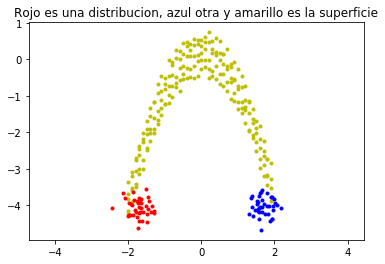

In [65]:
puntos=40

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1)
W=np.concatenate((x,y),axis=1)


dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) -0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) +0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) -0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) +0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)




y1, y2 = np.random.multivariate_normal([1.7,-4], [[0.05,0],[0,0.05]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=Ycol.flatten()


x1, x2 = np.random.multivariate_normal([-1.7,-4], [[0.05,0],[0,0.05]], puntos).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Zcol=np.concatenate((x1,x2),axis=1)
Z=Zcol.flatten()





plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
plt.show()

# ACA ARRANCA LO NUEVO

## Tomo la dist de fermat al cuadrado por lo que dijo esteban, sino cualquier solucion en la geodesica va a ser lo mismo

In [66]:
data=np.concatenate((Zcol,Ycol,W),axis=0)


x=np.concatenate((Zcol,Ycol),axis=0) #los datos X iniciales, las distribuciones. 
z=np.matrix([0 for i in range(Zcol.shape[0])]+[1 for i in range(Ycol.shape[0])]).T
#le pongo label 0 a la primera y 1 a la segunda




alpha=3
k=5
dimension=2
h=np.std(x)*1.06*(x.shape[0]**(-1/5)) #TODO (es el bandwith de los kernel)
f_dist,tree=fermat_graph(data,alpha=alpha)
f_dist=f_dist**2


#PUSE EL CUADRADO PERO NO CAMBIE EL GRADIENTE!
#(HABRIA QUE REESCALARLO CON UN 2*DIST_FERMAT),NO? TODO

### Defino las funciones que utilizan en el paper de tabak. Basicamente los nucleos y sus gradientes (armo una matriz que tiene el resultado de los kernel con los posibles centros evaluados en  los posibles puntos), esta matriz C que definen, el lagrangiano y su gradiente 

In [67]:
#ARMO LA MATRIZ C    
#vector con los valores z que hay, una matriz por filas paso
#viene en el mismo orden que los y
def armar_C(z,b=1):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=kernel(z[j],z[i],b,1)
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=0).reshape(-1,1)
    return C

def armar_C_categorico(z):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=0
            if(z[i]==z[j]):
                aux=1
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=0).reshape(-1,1)
    return C





#DEFINO LOS KERNEL Y SUS GRADIENTES (DERIVO EN PRIMER COORDENADA)
def kernel2(x,centro):
    return np.exp( -np.linalg.norm(x-centro)**2/(2*(h**2)) )/np.sqrt((2*np.pi)**dimension) 
     
def kernel_grad2(x,centro):
    return -(1/(h**2))*(x-centro)*np.exp( -np.linalg.norm(x-centro)**2/(2*(h**2)) )/np.sqrt((2*np.pi)**dimension) 




#matriz que tieneen el lugar ij al kernel(y_i,y_j) y
#lo mismo con gradiente_ij (en la primer coord derivo el kernel de centro y_j y evaluo en y_i)
#TENGO QUE HACERLO MAS RAPIDO ESTO!!
def kernel_matrix_y2(y):
        y_matrix=np.zeros((y.shape[0],y.shape[0]))
        for i in range(y.shape[0]):
            y_matrix[i,:]=np.array([kernel2(y[i,:],y[j,:])  for j in range(y.shape[0])]).reshape(1,-1)
        return y_matrix
    
def grad_matrix_y2(y):
        grad_matrix=np.zeros((y.shape[0],y.shape[0],dimension))
        for i in range(y.shape[0]):
            for j in range(y.shape[0]):
                grad_matrix[i,j,:]=kernel_grad2(y[i,:],y[j,:])
        return grad_matrix
                
        
        
        
        
#AHORA DEFINO LAGRANGIANO Y SU GRADIENTE                
def lagrangiano(landa,kernel_matrix,C,cost): 
    return  cost+ landa * (kernel_matrix.flatten() @ C.flatten())
#el lagrangiano es: sum_i[ cost(x_i,y_i)+ sum_k[landa*kernel(y_i,y_k)*C_il]   ]
    
    
    
    
    
#el gradiente de la parte de la F del lagrangiano
def fgrad(y,grad_matrix,C): 
    dimension=y.shape[1]
    aux=np.zeros(y.shape).flatten()
    for i in range (y.shape[0]):
        local_grad=C[i,:]@grad_matrix[i,:,:]
        aux[i*dimension:(i+1)*dimension]= local_grad
    return aux




# derivo en y_i
def lagrangiano_grad(landa,cost_grad,f_grad):
    return cost_grad+landa*f_grad






#La cuenta de como actualizar el landamin,hace la cuenta de que desciendo en direccion de L_F (que aca llamo f_grad)
def landamin_actualizacion(cost_grad,f_grad):
    num=cost_grad@f_grad
    denom=f_grad@f_grad
    return num/denom

### Tratando de paralelizar asi no es una tortuga (lo hago principalmente con lo de los kernels y su gradiente que es una cuenta que hago mucho y grande)

In [68]:
import scipy
from scipy.spatial.distance import pdist, cdist,squareform

#matriz que tieneen el lugar ij al kernel(y_i,y_j) 
def kernel_matrix_y(y):
    pairwise_dists = squareform(pdist(y, 'euclidean'))
    return scipy.exp( -pairwise_dists**2/(2*(h**2))) / (np.sqrt( (2*np.pi)**dimension) )
    
    

    
def grad_matrix_y(y):
    pairwise_dists=squareform(pdist(y,'euclidean'))
    #armo la matriz que tiene el escalar por el que multiplico a la direccion
    aux=scipy.exp( -pairwise_dists**2/(2*(h**2))) / (np.sqrt( (2*np.pi)**dimension))
    aux=aux*(-1/(h**2))
    
    #simplemente hago en cada coordenada (De las d dimensiones) la resta de los y correspondeintes
    #en el lugar ij tendre y_i-y_j y eso luego lo multiplico por aux.
    unos=np.ones((y.shape[0],1))
    res=np.zeros((y.shape[0],y.shape[0],dimension))
    for d in range(dimension):
        res[:,:,d]=(y[:,d].reshape(-1,1)) @unos.T -  unos @ (y[:,d].reshape(-1,1)).T  
        res[:,:,d]=res[:,:,d]*aux
    return res
       

In [69]:
%%time
y=np.random.random((100,dimension))
asd=kernel_matrix_y(y)
asdd=grad_matrix_y(y)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 19.9 ms


In [70]:
%%time 
#VEMOS QUE ESTE TARDA MUCHO MAS, AHORA ES MAS EFICIENTE


asd2=kernel_matrix_y2(y)
asdd2=grad_matrix_y2(y)

CPU times: user 4.84 s, sys: 216 ms, total: 5.06 s
Wall time: 4.83 s


In [71]:
#CHEQUEO QUE EFECTIVAMENTE DE LO MISMO...
print(np.alltrue(asd2-asd<1e19),np.alltrue(asdd2-asdd<1e19))


True True


In [73]:
def kernel_matrix_y_centros2(y,centros):
    mat=np.zeros((y.shape[0],y.shape[0]))
    for i in range(y.shape[0]):
        for j in range(centros.shape[0]):
            d=np.linalg.norm(y[i,:]-centros[j,:])
            mat[i,j]=np.exp(-d**2/(2*(h**2))) / (np.sqrt( (2*np.pi)**dimension) )
    return mat

def kernel_matrix_y_centros(y,centros):
    pairwise_dists = cdist(y,centros, 'euclidean')
    return scipy.exp( -pairwise_dists**2/(2*(h**2))) / (np.sqrt( (2*np.pi)**dimension) )

In [74]:

y=np.random.random((100,dimension))
centros=np.random.random((100,dimension))

In [75]:
%%time

asd=kernel_matrix_y_centros2(y,centros)

CPU times: user 1.82 s, sys: 52 ms, total: 1.87 s
Wall time: 1.84 s


In [76]:
%%time 

asdd=kernel_matrix_y_centros(y,centros)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.43 ms


In [77]:
np.alltrue(asdd-asd<1e-15)

True

### El algoritmo que proponen (falta poner bien la formula del landamin que no la hice aun, ver que seria un buen beta y un buen landamax -ademas de una learningrate inicial y un h (el bandwith) inicial-)

In [84]:
#x va a ser los puntos iniciales (distintas distribuciones)
#y van a ser los transportados (baricentro)


niter=10000
learningrate0=1 #TODO 
landamax=10e10 #TODO
landa0=1#TODO


y=x
#y=10*np.random.random(x.shape)

C=armar_C_categorico(z) #en z pongo fila a fila los distintos valores de z
landa=landa0
learningrate=learningrate0
n=0

while (n<niter):
    learningrate=min(learningrate*2.01,learningrate0)
    
    #cost,cost_grad=fermat_cost(y.flatten(),x,dimension,f_dist,tree,data,k,alpha)
    cost,cost_grad=euclidean_cost(y.flatten(),x)
    
    
    grad_matrix=grad_matrix_y(y)
    f_grad=fgrad(y,grad_matrix,C)
    
    kernel_matrix=kernel_matrix_y(y)
    
    
    beta=landa*0.1
    landamin=beta-landamin_actualizacion(cost_grad,f_grad)
    
    
    
    if(landamin>landa and landamin<landamax): 
        landa=landamin
    elif(landamin>landamax): 
        landa=landamax
    
    
    gradienteLagrangiano=lagrangiano_grad(landa,cost_grad,f_grad)
    yviejo=y
    costviejo=cost
    
    
    while(True):
        y=(yviejo.flatten()-(learningrate*gradienteLagrangiano)).reshape(yviejo.shape)  
        kernel_matrix=kernel_matrix_y(y) 
        
        #cost,cost_grad=fermat_cost(y.flatten(),x,dimension,f_dist,tree,data,k,alpha)
        cost,cost_grad=euclidean_cost(y.flatten(),x)
       
        lag_nuevo=lagrangiano(landa,kernel_matrix,C,cost)
        kernel_matrix=kernel_matrix_y_centros(y,yviejo)
        lag_viejo=lagrangiano(landa,kernel_matrix,C,costviejo)
        
        if(lag_nuevo<=lag_viejo): 
            break #es que el lagrangiano nuevo disminuyo efectivamente (uso el y nuevo en ambos -kernel_matrix- pero el costo que a cada uno le corresponde)
        learningrate=learningrate/2             
      
    print("it: "+str(n)+", paso: "+str(learningrate*np.linalg.norm(gradienteLagrangiano))+", landa: "+str(landa))
    n=n+1

it: 0, paso: 0.1844656032560203, landa: 1
it: 1, paso: 0.019559382545133282, landa: 2.0200324697449368
it: 2, paso: 0.03908411968173567, landa: 2.313185092474186
it: 3, paso: 0.04512953658902256, landa: 2.7269232939246795
it: 4, paso: 0.05354663282139663, landa: 3.203990934072473
it: 5, paso: 0.06362647696264934, landa: 3.7615770560430137
it: 6, paso: 0.07548878379745945, landa: 4.409250346231958
it: 7, paso: 0.0897833956963722, landa: 5.162100613591739
it: 8, paso: 0.1066678686243506, landa: 6.033124538055185
it: 9, paso: 0.12694908628686838, landa: 7.040812902705978
it: 10, paso: 0.15099787997733174, landa: 8.202621683947921
it: 11, paso: 0.17980873697946448, landa: 9.542312484149535
it: 12, paso: 0.21405547972709732, landa: 11.085258641441516
it: 13, paso: 0.25498388047854453, landa: 12.865859347008506
it: 14, paso: 0.30366447060493623, landa: 14.926133887213078
it: 15, paso: 0.18085902771167683, landa: 17.324534509659344
it: 16, paso: 0.21233980689494109, landa: 18.85090236562061
i

it: 138, paso: 0.02264206022854711, landa: 5343.0136172814855
it: 139, paso: 0.02558297991715074, landa: 5474.193369859932
it: 140, paso: 0.05326161261558924, landa: 5679.6599498836
it: 141, paso: 0.11552111418217835, landa: 5901.5607732225935
it: 142, paso: 0.03555093567351372, landa: 5901.5607732225935
it: 143, paso: 0.02748717926900684, landa: 6019.1092972181605
it: 144, paso: 0.05663975017260266, landa: 6166.797846309044
it: 145, paso: 0.06094959799712799, landa: 6286.184731665482
it: 146, paso: 0.02338403030237617, landa: 6286.184731665482
it: 147, paso: 0.02927682487128562, landa: 6364.7917637588735
it: 148, paso: 0.05987328963992424, landa: 6433.715975053152
it: 149, paso: 0.037742712914809344, landa: 6433.715975053152
it: 150, paso: 0.0219091400800735, landa: 6433.715975053152
it: 151, paso: 0.03009435125713543, landa: 6512.8142758703225
it: 152, paso: 0.06206381708935406, landa: 6575.589015071726
it: 153, paso: 0.022492687035916368, landa: 6575.589015071726
it: 154, paso: 0.03

it: 271, paso: 0.013450255413072713, landa: 12511.425775031492
it: 272, paso: 0.027773191071505828, landa: 13030.214294557283
it: 273, paso: 0.057197525972920125, landa: 13635.627203714483
it: 274, paso: 0.011338758445197553, landa: 13635.627203714483
it: 275, paso: 0.013692661440588135, landa: 13908.146824207375
it: 276, paso: 0.029167377781849375, landa: 14497.94428945166
it: 277, paso: 0.012546684497080473, landa: 14497.94428945166
it: 278, paso: 0.014468158835037844, landa: 14657.102344855919
it: 279, paso: 0.016443567018735717, landa: 14911.309487288034
it: 280, paso: 0.010452636980094406, landa: 14911.309487288034
it: 281, paso: 0.014407035225968392, landa: 15324.011184436307
it: 282, paso: 0.008374302323877942, landa: 15634.123164286288
it: 283, paso: 0.01415986021245277, landa: 15920.43306266066
it: 284, paso: 0.016205608713116992, landa: 16554.094843466177
it: 285, paso: 0.01099237837419119, landa: 16554.094843466177
it: 286, paso: 0.016290888615645507, landa: 16719.0706621107

it: 405, paso: 0.006208603995929482, landa: 47820.7603994738
it: 406, paso: 0.006376910414776922, landa: 47820.7603994738
it: 407, paso: 0.012934009796089581, landa: 47820.7603994738
it: 408, paso: 0.026492458844646828, landa: 47820.7603994738
it: 409, paso: 0.056806861998571156, landa: 47820.7603994738
it: 410, paso: 0.013340781175434257, landa: 47820.7603994738
it: 411, paso: 0.007633152064188919, landa: 47820.7603994738
it: 412, paso: 0.015522690180841738, landa: 47820.7603994738
it: 413, paso: 0.01699618939816984, landa: 47820.7603994738
it: 414, paso: 0.006454603869725643, landa: 47820.7603994738
it: 415, paso: 0.008231516057513754, landa: 47820.7603994738
it: 416, paso: 0.01674472255969944, landa: 47820.7603994738
it: 417, paso: 0.03541701515148318, landa: 47820.7603994738
it: 418, paso: 0.009446081570060489, landa: 47820.7603994738
it: 419, paso: 0.009236568848846325, landa: 47820.7603994738
it: 420, paso: 0.01886286137785121, landa: 47820.7603994738
it: 421, paso: 0.01099105435

it: 540, paso: 0.006605516583364915, landa: 51355.78360249153
it: 541, paso: 0.0070229199103871865, landa: 53212.360555808074
it: 542, paso: 0.003880546382583945, landa: 53212.360555808074
it: 543, paso: 0.005325703346833778, landa: 53212.360555808074
it: 544, paso: 0.01056342944339803, landa: 53212.360555808074
it: 545, paso: 0.0061585257332366136, landa: 56157.19222228207
it: 546, paso: 0.003424756485281252, landa: 56157.19222228207
it: 547, paso: 0.005307918805324492, landa: 56157.19222228207
it: 548, paso: 0.010652084376650602, landa: 56157.19222228207
it: 549, paso: 0.0037459273972592433, landa: 61072.45086224047
it: 550, paso: 0.005703185631386102, landa: 61072.45086224047
it: 551, paso: 0.006163696556619814, landa: 62188.53015795772
it: 552, paso: 0.003710214260866658, landa: 62188.53015795772
it: 553, paso: 0.005669485784184257, landa: 62188.53015795772
it: 554, paso: 0.0063508634067648865, landa: 62188.53015795772
it: 555, paso: 0.004204907675992517, landa: 65775.08951853706
i

it: 671, paso: 0.0010079867182883526, landa: 255717.03689780826
it: 672, paso: 0.0006058496811761152, landa: 255717.03689780826
it: 673, paso: 0.0008845384507269794, landa: 259926.22176763933
it: 674, paso: 0.0009596250304236566, landa: 265535.6892799528
it: 675, paso: 0.00056014112396416, landa: 265535.6892799528
it: 676, paso: 0.0009104041432541519, landa: 270213.4482410782
it: 677, paso: 0.0009896770966394755, landa: 272037.41561671253
it: 678, paso: 0.000604345365403614, landa: 272037.41561671253
it: 679, paso: 0.0009457249343296593, landa: 275240.7720113075
it: 680, paso: 0.000544733670575871, landa: 275240.7720113075
it: 681, paso: 0.0009294939553767559, landa: 277514.0635867593
it: 682, paso: 0.0010511970945699237, landa: 280725.2143478162
it: 683, paso: 0.0007087054492572112, landa: 280725.2143478162
it: 684, paso: 0.0010479830871286799, landa: 283542.3726264488
it: 685, paso: 0.0007124779214787354, landa: 283542.3726264488
it: 686, paso: 0.0010674189654390053, landa: 285085.70

it: 802, paso: 0.00045140221109322867, landa: 679973.6002764868
it: 803, paso: 0.0004903975266773238, landa: 695084.2916703441
it: 804, paso: 0.00031844101497682104, landa: 695084.2916703441
it: 805, paso: 0.0002745200261794161, landa: 695084.2916703441
it: 806, paso: 0.0005037096780758348, landa: 695084.2916703441
it: 807, paso: 0.0003461679813602162, landa: 695084.2916703441
it: 808, paso: 0.00029490626417899357, landa: 695084.2916703441
it: 809, paso: 0.0005320019057643133, landa: 695084.2916703441
it: 810, paso: 0.00020235183726508463, landa: 695084.2916703441
it: 811, paso: 0.00023746732056466072, landa: 704570.8172622169
it: 812, paso: 0.0004817899806169088, landa: 721032.5511484457
it: 813, paso: 0.0005187495751929457, landa: 731471.8357025184
it: 814, paso: 0.0001773447307357492, landa: 731471.8357025184
it: 815, paso: 0.000245120346726061, landa: 738958.2372978539
it: 816, paso: 0.0004975838027653629, landa: 750235.0718792994
it: 817, paso: 0.0010212862855656045, landa: 759925

it: 934, paso: 0.00019675388547284365, landa: 1069666.504793633
it: 935, paso: 0.00024966860270961706, landa: 1070923.701212841
it: 936, paso: 0.000530475925454945, landa: 1070923.701212841
it: 937, paso: 0.00013187327850906885, landa: 1070923.701212841
it: 938, paso: 0.00014834727408752216, landa: 1070923.701212841
it: 939, paso: 0.00024607474590176775, landa: 1071387.6812024743
it: 940, paso: 0.0005091203383059368, landa: 1078008.251341986
it: 941, paso: 0.00019716659043996854, landa: 1078008.251341986
it: 942, paso: 0.00026228197519998224, landa: 1078008.251341986
it: 943, paso: 0.0002882681635462119, landa: 1078008.251341986
it: 944, paso: 0.00017369797784896494, landa: 1078008.251341986
it: 945, paso: 0.0002604080375161158, landa: 1078008.251341986
it: 946, paso: 0.0002808923684463222, landa: 1078008.251341986
it: 947, paso: 0.00016526498503897376, landa: 1078008.251341986
it: 948, paso: 0.0002642494641727657, landa: 1091007.142653997
it: 949, paso: 0.00028466899757669824, landa: 

it: 1061, paso: 0.00011253059309188659, landa: 1290364.9069093575
it: 1062, paso: 0.0001281442291067116, landa: 1290364.9069093575
it: 1063, paso: 0.00023552714020754173, landa: 1290364.9069093575
it: 1064, paso: 0.0004968850393144346, landa: 1290364.9069093575
it: 1065, paso: 0.00012221512959778572, landa: 1290364.9069093575
it: 1066, paso: 0.0001312943231825377, landa: 1290364.9069093575
it: 1067, paso: 0.00024144757927943404, landa: 1296086.344192856
it: 1068, paso: 0.0005174302006038182, landa: 1296086.344192856
it: 1069, paso: 0.00014244682429266663, landa: 1296086.344192856
it: 1070, paso: 0.00013707023617059397, landa: 1296086.344192856
it: 1071, paso: 0.00024823166367258343, landa: 1296086.344192856
it: 1072, paso: 0.00027426118887694613, landa: 1296086.344192856
it: 1073, paso: 0.00017963630123448524, landa: 1296086.344192856
it: 1074, paso: 0.00027791783961005095, landa: 1296086.344192856
it: 1075, paso: 0.00018472305491039773, landa: 1296086.344192856
it: 1076, paso: 0.00028

it: 1187, paso: 0.00014098117485365275, landa: 1502595.2802221335
it: 1188, paso: 0.00024132874298139116, landa: 1505167.7922320757
it: 1189, paso: 0.00015173347148413717, landa: 1505167.7922320757
it: 1190, paso: 0.00025205392473334336, landa: 1505167.7922320757
it: 1191, paso: 0.00016951934988803936, landa: 1505167.7922320757
it: 1192, paso: 0.00026974747712541245, landa: 1505167.7922320757
it: 1193, paso: 9.937193112200228e-05, landa: 1505167.7922320757
it: 1194, paso: 0.00011807102584592803, landa: 1505167.7922320757
it: 1195, paso: 0.00023258661209571454, landa: 1517705.3025673465
it: 1196, paso: 0.0004937722489135296, landa: 1517705.3025673465
it: 1197, paso: 0.00013700055011500742, landa: 1517705.3025673465
it: 1198, paso: 0.00012431248466514638, landa: 1517705.3025673465
it: 1199, paso: 0.00024031073462138391, landa: 1517705.3025673465
it: 1200, paso: 0.0002706933359182623, landa: 1517705.3025673465
it: 1201, paso: 9.905662720551083e-05, landa: 1517705.3025673465
it: 1202, paso

it: 1315, paso: 8.570522791822935e-05, landa: 1699317.0746540246
it: 1316, paso: 0.00010804631797436573, landa: 1700258.0834069154
it: 1317, paso: 0.00021428283995806888, landa: 1700258.0834069154
it: 1318, paso: 0.0004506873683223782, landa: 1700919.6958692926
it: 1319, paso: 0.00011888748236982936, landa: 1700919.6958692926
it: 1320, paso: 0.00011225719186449851, landa: 1700919.6958692926
it: 1321, paso: 0.00022091250241490615, landa: 1704305.0365201568
it: 1322, paso: 0.000244303742747264, landa: 1704305.0365201568
it: 1323, paso: 8.784859122717399e-05, landa: 1704305.0365201568
it: 1324, paso: 0.0001110579127434075, landa: 1704305.0365201568
it: 1325, paso: 0.00022170101526000272, landa: 1704305.0365201568
it: 1326, paso: 0.00046315517619544027, landa: 1704305.0365201568
it: 1327, paso: 0.00011894489714513134, landa: 1704305.0365201568
it: 1328, paso: 0.00011411035511580206, landa: 1704305.0365201568
it: 1329, paso: 0.0002272146811952487, landa: 1705845.9371686147
it: 1330, paso: 0

it: 1441, paso: 0.0001127403968086168, landa: 1902634.5142316867
it: 1442, paso: 0.0001033536961332168, landa: 1902634.5142316867
it: 1443, paso: 0.000204735031090432, landa: 1902753.2866324931
it: 1444, paso: 0.00022520235411855423, landa: 1902753.2866324931
it: 1445, paso: 8.144757506776803e-05, landa: 1902753.2866324931
it: 1446, paso: 0.00010279285006967774, landa: 1902753.2866324931
it: 1447, paso: 0.0002057742914817802, landa: 1902753.2866324931
it: 1448, paso: 0.00042736815511289396, landa: 1903513.2352683535
it: 1449, paso: 0.00010513691292866873, landa: 1903513.2352683535
it: 1450, paso: 0.00010502368141058182, landa: 1903513.2352683535
it: 1451, paso: 0.000210097116348674, landa: 1903513.2352683535
it: 1452, paso: 0.00044489806017115657, landa: 1903513.2352683535
it: 1453, paso: 0.00013230011486199423, landa: 1903513.2352683535
it: 1454, paso: 0.00010701217363663068, landa: 1903513.2352683535
it: 1455, paso: 0.00021416541369972104, landa: 1903513.2352683535
it: 1456, paso: 0.

it: 1567, paso: 0.00012528170597463165, landa: 2132976.351567331
it: 1568, paso: 9.76329699217332e-05, landa: 2132976.351567331
it: 1569, paso: 0.00019501919614311474, landa: 2132976.351567331
it: 1570, paso: 0.00021279270514633814, landa: 2132976.351567331
it: 1571, paso: 7.80314241776245e-05, landa: 2132976.351567331
it: 1572, paso: 9.774099801894663e-05, landa: 2132976.351567331
it: 1573, paso: 0.00019623564884849482, landa: 2132976.351567331
it: 1574, paso: 0.0004010810235107985, landa: 2132976.351567331
it: 1575, paso: 8.217873514261493e-05, landa: 2132976.351567331
it: 1576, paso: 9.931475374020749e-05, landa: 2132976.351567331
it: 1577, paso: 0.00019948541886758298, landa: 2132976.351567331
it: 1578, paso: 0.00040547350150590527, landa: 2132976.351567331
it: 1579, paso: 7.523265958663474e-05, landa: 2132976.351567331
it: 1580, paso: 0.00010090327693174653, landa: 2132976.351567331
it: 1581, paso: 0.00020273289605766251, landa: 2132976.351567331
it: 1582, paso: 0.0004087435606833

it: 1696, paso: 7.473371720093478e-05, landa: 2372034.171833277
it: 1697, paso: 9.277433797431569e-05, landa: 2372034.171833277
it: 1698, paso: 0.00018639787541736697, landa: 2372034.171833277
it: 1699, paso: 0.00037646860224253874, landa: 2372034.171833277
it: 1700, paso: 0.00011833125543788306, landa: 2372034.171833277
it: 1701, paso: 0.00011770268900851076, landa: 2372034.171833277
it: 1702, paso: 0.00011753815436130473, landa: 2372034.171833277
it: 1703, paso: 0.00011780504447266772, landa: 2372034.171833277
it: 1704, paso: 0.0001184930062207565, landa: 2372034.171833277
it: 1705, paso: 0.00011961307501916724, landa: 2372034.171833277
it: 1706, paso: 0.00012119835887538929, landa: 2372034.171833277
it: 1707, paso: 0.00012330625013578305, landa: 2372034.171833277
it: 1708, paso: 0.00012602230938747687, landa: 2372034.171833277
it: 1709, paso: 0.0001294660378882523, landa: 2372034.171833277
it: 1710, paso: 0.00013379878909642112, landa: 2372034.171833277
it: 1711, paso: 6.96171251393

it: 1827, paso: 0.00012002150295618661, landa: 2745903.23354511
it: 1828, paso: 9.544289726407268e-05, landa: 2745903.23354511
it: 1829, paso: 0.00019408561392821936, landa: 2770242.911569283
it: 1830, paso: 0.00012019277408014878, landa: 2770242.911569283
it: 1831, paso: 6.587555457330045e-05, landa: 2800652.1049680207
it: 1832, paso: 9.749527809867517e-05, landa: 2800652.1049680207
it: 1833, paso: 0.00019674360339672504, landa: 2800652.1049680207
it: 1834, paso: 0.00011116061058974891, landa: 2800652.1049680207
it: 1835, paso: 0.00012099517051753927, landa: 2905295.5301167374
it: 1836, paso: 6.877116636607646e-05, landa: 2905295.5301167374
it: 1837, paso: 0.00010371529668344754, landa: 2905295.5301167374
it: 1838, paso: 0.00021171502010361638, landa: 2905295.5301167374
it: 1839, paso: 7.267390918140528e-05, landa: 2905295.5301167374
it: 1840, paso: 0.00010582643927419405, landa: 2905295.5301167374
it: 1841, paso: 0.0002182874383368627, landa: 2916973.8797736457
it: 1842, paso: 8.2951

it: 1956, paso: 8.279587048826537e-05, landa: 3529889.193219842
it: 1957, paso: 0.0001118502110607741, landa: 3529889.193219842
it: 1958, paso: 0.00012688873230010404, landa: 3593204.920869522
it: 1959, paso: 8.127849070021446e-05, landa: 3593204.920869522
it: 1960, paso: 0.00011594425530059172, landa: 3593204.920869522
it: 1961, paso: 6.734642140710014e-05, landa: 3593204.920869522
it: 1962, paso: 0.00011192116859069958, landa: 3593204.920869522
it: 1963, paso: 0.00012215700490133554, landa: 3593204.920869522
it: 1964, paso: 7.518180605036724e-05, landa: 3593204.920869522
it: 1965, paso: 0.00011688642436869831, landa: 3593204.920869522
it: 1966, paso: 0.000135097621352958, landa: 3639660.4577067737
it: 1967, paso: 9.218551920307004e-05, landa: 3639660.4577067737
it: 1968, paso: 0.00012980269123205026, landa: 3650108.9773209738
it: 1969, paso: 8.493876453289864e-05, landa: 3650108.9773209738
it: 1970, paso: 0.00012766936084203855, landa: 3650108.9773209738
it: 1971, paso: 8.15392478322

it: 2085, paso: 7.363560544983628e-05, landa: 3992139.2282006573
it: 2086, paso: 0.00011308124817697956, landa: 3992139.2282006573
it: 2087, paso: 6.754048446801107e-05, landa: 4004293.655223569
it: 2088, paso: 0.00011168172587995952, landa: 4004293.655223569
it: 2089, paso: 0.00012928184531120252, landa: 4034251.395440248
it: 2090, paso: 9.017063896767537e-05, landa: 4034251.395440248
it: 2091, paso: 0.0001281686940828832, landa: 4041782.3389332145
it: 2092, paso: 8.862428066328009e-05, landa: 4041782.3389332145
it: 2093, paso: 0.00012924559671986975, landa: 4046996.012522091
it: 2094, paso: 9.013014720254e-05, landa: 4046996.012522091
it: 2095, paso: 0.0001323808662086977, landa: 4053238.373121081
it: 2096, paso: 4.736959741314318e-05, landa: 4053238.373121081
it: 2097, paso: 5.80132254055253e-05, landa: 4053238.373121081
it: 2098, paso: 0.00011254502527541437, landa: 4053238.373121081
it: 2099, paso: 0.00023764796188332335, landa: 4053238.373121081
it: 2100, paso: 6.140617045076415e

it: 2214, paso: 7.956572434961074e-05, landa: 4303055.725853853
it: 2215, paso: 0.00011546839928261323, landa: 4303055.725853853
it: 2216, paso: 7.620869229455229e-05, landa: 4303055.725853853
it: 2217, paso: 0.00011490137814070216, landa: 4303055.725853853
it: 2218, paso: 7.51102405322216e-05, landa: 4303055.725853853
it: 2219, paso: 0.00011564578830908445, landa: 4303055.725853853
it: 2220, paso: 7.592672896875854e-05, landa: 4303055.725853853
it: 2221, paso: 0.00011763513266449768, landa: 4303055.725853853
it: 2222, paso: 7.87046138381518e-05, landa: 4303055.725853853
it: 2223, paso: 0.00012117809039504653, landa: 4315460.643492128
it: 2224, paso: 8.395430352626749e-05, landa: 4315460.643492128
it: 2225, paso: 6.364962265376511e-05, landa: 4329231.974105727
it: 2226, paso: 0.00011286313212405499, landa: 4329231.974105727
it: 2227, paso: 6.86498870410765e-05, landa: 4329231.974105727
it: 2228, paso: 0.0001177264862555559, landa: 4329231.974105727
it: 2229, paso: 7.685637530532516e-05

it: 2342, paso: 0.00011060433485276945, landa: 4693056.092038726
it: 2343, paso: 7.392290812432083e-05, landa: 4693056.092038726
it: 2344, paso: 0.00011351373590656, landa: 4693056.092038726
it: 2345, paso: 7.820946721654889e-05, landa: 4693056.092038726
it: 2346, paso: 0.00011825468878216133, landa: 4693056.092038726
it: 2347, paso: 4.2702879049891104e-05, landa: 4693056.092038726
it: 2348, paso: 5.1816645082640625e-05, landa: 4693056.092038726
it: 2349, paso: 0.0001008464006907108, landa: 4693056.092038726
it: 2350, paso: 0.0002134780738497002, landa: 4693056.092038726
it: 2351, paso: 5.658649598193966e-05, landa: 4693056.092038726
it: 2352, paso: 5.456710505476056e-05, landa: 4693056.092038726
it: 2353, paso: 0.00010422013010249795, landa: 4693056.092038726
it: 2354, paso: 0.00011591927978329993, landa: 4693056.092038726
it: 2355, paso: 8.05227781339818e-05, landa: 4693056.092038726
it: 2356, paso: 6.423985266254821e-05, landa: 4693056.092038726
it: 2357, paso: 0.0001139739389140757

it: 2471, paso: 6.474124857824524e-05, landa: 4817090.681110739
it: 2472, paso: 0.00010038962837992576, landa: 4817090.681110739
it: 2473, paso: 6.374464170042137e-05, landa: 4817090.681110739
it: 2474, paso: 0.00010096900924119031, landa: 4817090.681110739
it: 2475, paso: 6.424871569351175e-05, landa: 4817090.681110739
it: 2476, paso: 0.00010247892737476992, landa: 4817090.681110739
it: 2477, paso: 6.625215336053468e-05, landa: 4817090.681110739
it: 2478, paso: 0.00010507166492751613, landa: 4817090.681110739
it: 2479, paso: 7.006479051885396e-05, landa: 4817090.681110739
it: 2480, paso: 0.00010924729011893679, landa: 4831252.842185226
it: 2481, paso: 7.644641308247496e-05, landa: 4831252.842185226
it: 2482, paso: 5.812381266906636e-05, landa: 4842783.73542007
it: 2483, paso: 0.00010248336166388771, landa: 4842783.73542007
it: 2484, paso: 6.386670280252367e-05, landa: 4842783.73542007
it: 2485, paso: 0.00010808201602792035, landa: 4842783.73542007
it: 2486, paso: 7.350219899867483e-05

it: 2600, paso: 9.183395268781294e-05, landa: 5019121.2958568875
it: 2601, paso: 5.5812562430458706e-05, landa: 5019121.2958568875
it: 2602, paso: 9.154913251144241e-05, landa: 5019121.2958568875
it: 2603, paso: 5.488116797365408e-05, landa: 5039279.50134663
it: 2604, paso: 9.234728906650969e-05, landa: 5039279.50134663
it: 2605, paso: 5.5394045647768055e-05, landa: 5045722.691636912
it: 2606, paso: 9.373166608616784e-05, landa: 5045722.691636912
it: 2607, paso: 5.705878409846817e-05, landa: 5045722.691636912
it: 2608, paso: 9.579919387861245e-05, landa: 5045722.691636912
it: 2609, paso: 6.0031201139994e-05, landa: 5045722.691636912
it: 2610, paso: 9.89300894696646e-05, landa: 5045722.691636912
it: 2611, paso: 6.488732548056874e-05, landa: 5045722.691636912
it: 2612, paso: 0.00010379309891269245, landa: 5045722.691636912
it: 2613, paso: 7.266391088561984e-05, landa: 5045722.691636912
it: 2614, paso: 5.5827706316001535e-05, landa: 5045722.691636912
it: 2615, paso: 9.830104025453788e-05,

it: 2728, paso: 5.0604313844405554e-05, landa: 5293095.130234119
it: 2729, paso: 8.512595099092095e-05, landa: 5293095.130234119
it: 2730, paso: 9.882055412839599e-05, landa: 5314694.20716328
it: 2731, paso: 6.975686345177059e-05, landa: 5314694.20716328
it: 2732, paso: 9.905982816408405e-05, landa: 5322105.678906316
it: 2733, paso: 7.01401529556709e-05, landa: 5322105.678906316
it: 2734, paso: 5.048842971001966e-05, landa: 5325581.386409787
it: 2735, paso: 8.812809003276035e-05, landa: 5325581.386409787
it: 2736, paso: 5.222059432414833e-05, landa: 5325581.386409787
it: 2737, paso: 9.011897947777378e-05, landa: 5325581.386409787
it: 2738, paso: 5.5113208292602126e-05, landa: 5325581.386409787
it: 2739, paso: 9.307358425049546e-05, landa: 5325581.386409787
it: 2740, paso: 5.9770647917875844e-05, landa: 5325581.386409787
it: 2741, paso: 9.766713749624801e-05, landa: 5325581.386409787
it: 2742, paso: 6.726503660789304e-05, landa: 5325581.386409787
it: 2743, paso: 5.259552607603754e-05, l

it: 2857, paso: 5.774346211731735e-05, landa: 5543031.759088399
it: 2858, paso: 8.600049494387148e-05, landa: 5543031.759088399
it: 2859, paso: 5.488216228085613e-05, landa: 5543031.759088399
it: 2860, paso: 8.539082777000346e-05, landa: 5543031.759088399
it: 2861, paso: 5.364780010298527e-05, landa: 5543031.759088399
it: 2862, paso: 8.56516152286544e-05, landa: 5543031.759088399
it: 2863, paso: 5.367688303024357e-05, landa: 5543031.759088399
it: 2864, paso: 8.66515390267594e-05, landa: 5543031.759088399
it: 2865, paso: 5.488335831198117e-05, landa: 5543031.759088399
it: 2866, paso: 8.844744816472208e-05, landa: 5543031.759088399
it: 2867, paso: 5.7429460592140025e-05, landa: 5543031.759088399
it: 2868, paso: 9.13225995439768e-05, landa: 5548754.5384983625
it: 2869, paso: 6.177680917247456e-05, landa: 5548754.5384983625
it: 2870, paso: 9.600634940798436e-05, landa: 5578012.908180656
it: 2871, paso: 3.453468175168069e-05, landa: 5578012.908180656
it: 2872, paso: 4.2424149778538346e-05, 

it: 2987, paso: 4.4913954960511345e-05, landa: 5816068.214425773
it: 2988, paso: 7.669026886095849e-05, landa: 5816068.214425773
it: 2989, paso: 8.786943471110554e-05, landa: 5816068.214425773
it: 2990, paso: 6.0780650251326685e-05, landa: 5816068.214425773
it: 2991, paso: 8.761896994937578e-05, landa: 5816068.214425773
it: 2992, paso: 6.0382490626863876e-05, landa: 5816068.214425773
it: 2993, paso: 8.85763733785362e-05, landa: 5816068.214425773
it: 2994, paso: 6.171718755319192e-05, landa: 5816068.214425773
it: 2995, paso: 9.078672253648357e-05, landa: 5816068.214425773
it: 2996, paso: 3.247570473845798e-05, landa: 5816068.214425773
it: 2997, paso: 3.9783412639399594e-05, landa: 5816068.214425773
it: 2998, paso: 7.716256127457325e-05, landa: 5816068.214425773
it: 2999, paso: 0.00016293079529218247, landa: 5816068.214425773
it: 3000, paso: 4.203773072007992e-05, landa: 5816068.214425773
it: 3001, paso: 4.184270803464742e-05, landa: 5816068.214425773
it: 3002, paso: 7.965997859683615e-0

it: 3115, paso: 4.3264055252973744e-05, landa: 6078726.267060794
it: 3116, paso: 7.250770828760259e-05, landa: 6078726.267060794
it: 3117, paso: 8.308825363975235e-05, landa: 6078726.267060794
it: 3118, paso: 5.706492770366313e-05, landa: 6078726.267060794
it: 3119, paso: 8.169674713876131e-05, landa: 6078726.267060794
it: 3120, paso: 5.506372446231907e-05, landa: 6078726.267060794
it: 3121, paso: 8.152871364628044e-05, landa: 6078726.267060794
it: 3122, paso: 5.4691684148343245e-05, landa: 6078726.267060794
it: 3123, paso: 8.236469399047152e-05, landa: 6078726.267060794
it: 3124, paso: 5.579273271268798e-05, landa: 6078726.267060794
it: 3125, paso: 8.423207134420583e-05, landa: 6078726.267060794
it: 3126, paso: 5.8499247692397046e-05, landa: 6078726.267060794
it: 3127, paso: 8.740892769083084e-05, landa: 6078726.267060794
it: 3128, paso: 3.162911034510627e-05, landa: 6078726.267060794
it: 3129, paso: 3.818758507004806e-05, landa: 6078726.267060794
it: 3130, paso: 7.418778531962965e-05

it: 3244, paso: 7.790666272583117e-05, landa: 6402962.771433978
it: 3245, paso: 5.266821235366497e-05, landa: 6402962.771433978
it: 3246, paso: 7.596763951483292e-05, landa: 6402962.771433978
it: 3247, paso: 4.986838635613127e-05, landa: 6402962.771433978
it: 3248, paso: 7.527282665986871e-05, landa: 6402962.771433978
it: 3249, paso: 4.865309782985204e-05, landa: 6402962.771433978
it: 3250, paso: 7.545839685305569e-05, landa: 6402962.771433978
it: 3251, paso: 4.868600838835996e-05, landa: 6402962.771433978
it: 3252, paso: 7.640065776450497e-05, landa: 6402962.771433978
it: 3253, paso: 4.9894599471172986e-05, landa: 6402962.771433978
it: 3254, paso: 7.816478330286627e-05, landa: 6402962.771433978
it: 3255, paso: 5.244602380659461e-05, landa: 6402962.771433978
it: 3256, paso: 8.107054161338592e-05, landa: 6420890.183929317
it: 3257, paso: 5.6835547037703425e-05, landa: 6420890.183929317
it: 3258, paso: 4.297244410623748e-05, landa: 6431098.240563502
it: 3259, paso: 7.562803694924327e-05,

it: 3373, paso: 6.601675879231187e-05, landa: 6661138.715439753
it: 3374, paso: 3.825080911854042e-05, landa: 6661138.715439753
it: 3375, paso: 6.537895424335981e-05, landa: 6661138.715439753
it: 3376, paso: 7.35615038968027e-05, landa: 6661138.715439753
it: 3377, paso: 4.895793634328587e-05, landa: 6661138.715439753
it: 3378, paso: 7.234530411730187e-05, landa: 6661138.715439753
it: 3379, paso: 4.707276763909983e-05, landa: 6661138.715439753
it: 3380, paso: 7.211807484702352e-05, landa: 6661138.715439753
it: 3381, paso: 4.651510993946926e-05, landa: 6661138.715439753
it: 3382, paso: 7.265416217210907e-05, landa: 6661138.715439753
it: 3383, paso: 4.709278031132819e-05, landa: 6661138.715439753
it: 3384, paso: 7.392520763013156e-05, landa: 6661138.715439753
it: 3385, paso: 4.884780183875374e-05, landa: 6661138.715439753
it: 3386, paso: 7.608510723816559e-05, landa: 6661138.715439753
it: 3387, paso: 5.206238225814459e-05, landa: 6661138.715439753
it: 3388, paso: 7.952188934100787e-05, la

it: 3502, paso: 3.1930704983848365e-05, landa: 6899306.085963208
it: 3503, paso: 3.357830960669314e-05, landa: 6899306.085963208
it: 3504, paso: 6.038132007657691e-05, landa: 6899306.085963208
it: 3505, paso: 0.00012945055941341704, landa: 6899306.085963208
it: 3506, paso: 3.523475384257227e-05, landa: 6899306.085963208
it: 3507, paso: 3.466152765532718e-05, landa: 6924051.068033288
it: 3508, paso: 6.216436605285862e-05, landa: 6924051.068033288
it: 3509, paso: 6.812549281798026e-05, landa: 6924051.068033288
it: 3510, paso: 4.343446036013899e-05, landa: 6924051.068033288
it: 3511, paso: 6.793745451765025e-05, landa: 6924051.068033288
it: 3512, paso: 4.288668427047733e-05, landa: 6924051.068033288
it: 3513, paso: 6.84022746794728e-05, landa: 6924051.068033288
it: 3514, paso: 4.332160665776417e-05, landa: 6924051.068033288
it: 3515, paso: 6.948136262437871e-05, landa: 6924051.068033288
it: 3516, paso: 4.4757213173127423e-05, landa: 6924051.068033288
it: 3517, paso: 7.129036826171664e-05,

it: 3630, paso: 3.5638623511385914e-05, landa: 7216686.918578693
it: 3631, paso: 5.835213016716541e-05, landa: 7216686.918578693
it: 3632, paso: 6.516824523755544e-05, landa: 7237563.128343448
it: 3633, paso: 4.203570231786777e-05, landa: 7237563.128343448
it: 3634, paso: 6.250997822853261e-05, landa: 7237563.128343448
it: 3635, paso: 3.817475732064652e-05, landa: 7237563.128343448
it: 3636, paso: 6.13004618522262e-05, landa: 7237563.128343448
it: 3637, paso: 3.605043521886272e-05, landa: 7237563.128343448
it: 3638, paso: 6.088294516954498e-05, landa: 7237563.128343448
it: 3639, paso: 6.994659475346863e-05, landa: 7237563.128343448
it: 3640, paso: 4.8431561949269945e-05, landa: 7237563.128343448
it: 3641, paso: 6.930833188765854e-05, landa: 7237563.128343448
it: 3642, paso: 4.750289134433107e-05, landa: 7237563.128343448
it: 3643, paso: 6.965930141138667e-05, landa: 7237563.128343448
it: 3644, paso: 4.794599677876268e-05, landa: 7237563.128343448
it: 3645, paso: 7.09373683869805e-05, l

it: 3760, paso: 5.527290669912411e-05, landa: 7532067.48417214
it: 3761, paso: 6.0989919222626654e-05, landa: 7532067.48417214
it: 3762, paso: 3.8402239534595984e-05, landa: 7532067.48417214
it: 3763, paso: 5.829656715399207e-05, landa: 7532067.48417214
it: 3764, paso: 3.446926338076733e-05, landa: 7532067.48417214
it: 3765, paso: 5.7139348231292594e-05, landa: 7532067.48417214
it: 3766, paso: 6.475956703021339e-05, landa: 7532067.48417214
it: 3767, paso: 4.3304113182116014e-05, landa: 7532067.48417214
it: 3768, paso: 6.275943068509493e-05, landa: 7532067.48417214
it: 3769, paso: 4.042108781314164e-05, landa: 7532067.48417214
it: 3770, paso: 6.190161933473588e-05, landa: 7532067.48417214
it: 3771, paso: 3.8949567838819506e-05, landa: 7532067.48417214
it: 3772, paso: 6.177927012122651e-05, landa: 7532067.48417214
it: 3773, paso: 3.848863812296944e-05, landa: 7532067.48417214
it: 3774, paso: 6.221007482413863e-05, landa: 7532067.48417214
it: 3775, paso: 3.8870061822965725e-05, landa: 753

it: 3891, paso: 2.4828692136792863e-05, landa: 7807554.416062839
it: 3892, paso: 2.8500793081509517e-05, landa: 7807554.416062839
it: 3893, paso: 5.2126803770607345e-05, landa: 7807554.416062839
it: 3894, paso: 0.00010961463921467153, landa: 7807554.416062839
it: 3895, paso: 2.6090565170446158e-05, landa: 7807554.416062839
it: 3896, paso: 2.900453375660148e-05, landa: 7807554.416062839
it: 3897, paso: 5.326403902400774e-05, landa: 7807554.416062839
it: 3898, paso: 0.00011309112680198889, landa: 7807554.416062839
it: 3899, paso: 2.9082301758829133e-05, landa: 7807554.416062839
it: 3900, paso: 2.9966520018448564e-05, landa: 7807554.416062839
it: 3901, paso: 5.464586018139963e-05, landa: 7807554.416062839
it: 3902, paso: 5.9171971586337405e-05, landa: 7807554.416062839
it: 3903, paso: 3.682008637806279e-05, landa: 7807554.416062839
it: 3904, paso: 5.9158898809032916e-05, landa: 7807554.416062839
it: 3905, paso: 3.651090285439922e-05, landa: 7807554.416062839
it: 3906, paso: 5.963799418803

it: 4020, paso: 3.247040022509021e-05, landa: 8109200.831503199
it: 4021, paso: 5.1056043368800535e-05, landa: 8109200.831503199
it: 4022, paso: 5.699015984077838e-05, landa: 8109200.831503199
it: 4023, paso: 3.6371720393148415e-05, landa: 8109200.831503199
it: 4024, paso: 5.358263984387792e-05, landa: 8109200.831503199
it: 4025, paso: 3.1690758860700715e-05, landa: 8109200.831503199
it: 4026, paso: 5.2150579084529346e-05, landa: 8109200.831503199
it: 4027, paso: 5.863792917616868e-05, landa: 8145491.460767794
it: 4028, paso: 3.842447446752956e-05, landa: 8145491.460767794
it: 4029, paso: 5.663940235131114e-05, landa: 8145491.460767794
it: 4030, paso: 3.5497773330019564e-05, landa: 8145491.460767794
it: 4031, paso: 5.574315963593443e-05, landa: 8145491.460767794
it: 4032, paso: 3.391774827749438e-05, landa: 8145491.460767794
it: 4033, paso: 5.5504703513420157e-05, landa: 8145491.460767794
it: 4034, paso: 3.322715668588551e-05, landa: 8145491.460767794
it: 4035, paso: 5.570854310827044e

it: 4149, paso: 4.3081757678007875e-05, landa: 8380813.414111543
it: 4150, paso: 5.2828532987189265e-05, landa: 8380813.414111543
it: 4151, paso: 3.2501634089805415e-05, landa: 8380813.414111543
it: 4152, paso: 4.930347381235022e-05, landa: 8380813.414111543
it: 4153, paso: 5.557303820612708e-05, landa: 8429292.937725615
it: 4154, paso: 3.5866584699416087e-05, landa: 8429292.937725615
it: 4155, paso: 5.1948528152601e-05, landa: 8429292.937725615
it: 4156, paso: 3.0987014847713465e-05, landa: 8429292.937725615
it: 4157, paso: 5.040658095795503e-05, landa: 8429292.937725615
it: 4158, paso: 5.695268861904986e-05, landa: 8429292.937725615
it: 4159, paso: 3.761487158911016e-05, landa: 8429292.937725615
it: 4160, paso: 5.453562507905694e-05, landa: 8429292.937725615
it: 4161, paso: 3.420047576850465e-05, landa: 8429292.937725615
it: 4162, paso: 5.3400469490774156e-05, landa: 8429292.937725615
it: 4163, paso: 3.2303041882612855e-05, landa: 8429292.937725615
it: 4164, paso: 5.299372268839381e-

it: 4278, paso: 4.536953198014985e-05, landa: 8659419.481702488
it: 4279, paso: 4.918945424284557e-05, landa: 8659419.481702488
it: 4280, paso: 2.92910813729925e-05, landa: 8659419.481702488
it: 4281, paso: 4.597123939701049e-05, landa: 8659419.481702488
it: 4282, paso: 5.00172570627815e-05, landa: 8659419.481702488
it: 4283, paso: 3.017870863385788e-05, landa: 8659419.481702488
it: 4284, paso: 4.704880368623597e-05, landa: 8659419.481702488
it: 4285, paso: 5.217602585665348e-05, landa: 8659419.481702488
it: 4286, paso: 3.2781674510499365e-05, landa: 8659419.481702488
it: 4287, paso: 4.8890572178267326e-05, landa: 8659419.481702488
it: 4288, paso: 5.665088891485152e-05, landa: 8712624.60459202
it: 4289, paso: 3.842223741166748e-05, landa: 8712624.60459202
it: 4290, paso: 5.291062549254036e-05, landa: 8712624.60459202
it: 4291, paso: 3.35429055491589e-05, landa: 8712624.60459202
it: 4292, paso: 5.1105312405953625e-05, landa: 8712624.60459202
it: 4293, paso: 3.080255516263377e-05, landa:

it: 4406, paso: 3.5274372451577766e-05, landa: 8991495.062524509
it: 4407, paso: 4.503933806712165e-05, landa: 8991495.062524509
it: 4408, paso: 5.106422482647988e-05, landa: 8991495.062524509
it: 4409, paso: 3.237685885829971e-05, landa: 8991495.062524509
it: 4410, paso: 4.50250386347117e-05, landa: 8991495.062524509
it: 4411, paso: 5.058697765163214e-05, landa: 9018576.768981554
it: 4412, paso: 3.194715186537893e-05, landa: 9018576.768981554
it: 4413, paso: 4.5904773154097174e-05, landa: 9018576.768981554
it: 4414, paso: 5.217410527573429e-05, landa: 9018576.768981554
it: 4415, paso: 3.386329242251159e-05, landa: 9018576.768981554
it: 4416, paso: 4.75423182040504e-05, landa: 9018576.768981554
it: 4417, paso: 2.7997874102438e-05, landa: 9018576.768981554
it: 4418, paso: 4.57721556303088e-05, landa: 9018576.768981554
it: 4419, paso: 5.0537581212331295e-05, landa: 9018576.768981554
it: 4420, paso: 3.179677616562725e-05, landa: 9018576.768981554
it: 4421, paso: 4.815620168382061e-05, lan

it: 4534, paso: 2.9234840450215504e-05, landa: 9201370.403446384
it: 4535, paso: 4.053583877267493e-05, landa: 9201370.403446384
it: 4536, paso: 8.647040529176418e-05, landa: 9201370.403446384
it: 4537, paso: 2.1968097141940658e-05, landa: 9201370.403446384
it: 4538, paso: 2.4108003965266155e-05, landa: 9201370.403446384
it: 4539, paso: 4.033106540322447e-05, landa: 9201370.403446384
it: 4540, paso: 8.380455009582403e-05, landa: 9201370.403446384
it: 4541, paso: 3.518704495337739e-05, landa: 9201370.403446384
it: 4542, paso: 4.410423811009093e-05, landa: 9201370.403446384
it: 4543, paso: 5.0703919404239745e-05, landa: 9290789.910154765
it: 4544, paso: 3.29034011594794e-05, landa: 9290789.910154765
it: 4545, paso: 4.480946679026509e-05, landa: 9290789.910154765
it: 4546, paso: 2.588420728990574e-05, landa: 9290789.910154765
it: 4547, paso: 4.290336943683308e-05, landa: 9290789.910154765
it: 4548, paso: 4.616856542643643e-05, landa: 9290789.910154765
it: 4549, paso: 2.7431399240791785e-0

it: 4663, paso: 3.4269254117981676e-05, landa: 9488214.354906583
it: 4664, paso: 3.946026702381547e-05, landa: 9488214.354906583
it: 4665, paso: 4.303369152750358e-05, landa: 9568081.703115016
it: 4666, paso: 2.51564416708939e-05, landa: 9568081.703115016
it: 4667, paso: 3.86685054534481e-05, landa: 9568081.703115016
it: 4668, paso: 8.103593128436137e-05, landa: 9568081.703115016
it: 4669, paso: 3.6492867702605956e-05, landa: 9568081.703115016
it: 4670, paso: 4.2373351451615574e-05, landa: 9568081.703115016
it: 4671, paso: 2.436236855721415e-05, landa: 9588118.325821701
it: 4672, paso: 3.9627815970446455e-05, landa: 9588118.325821701
it: 4673, paso: 8.34153352274108e-05, landa: 9588118.325821701
it: 4674, paso: 1.952865212891356e-05, landa: 9588118.325821701
it: 4675, paso: 2.2574596528799818e-05, landa: 9588118.325821701
it: 4676, paso: 3.997678818370099e-05, landa: 9588118.325821701
it: 4677, paso: 8.311651855753004e-05, landa: 9588118.325821701
it: 4678, paso: 3.535149072166202e-05,

it: 4793, paso: 3.112005660635116e-05, landa: 9849798.00823895
it: 4794, paso: 3.735909064087489e-05, landa: 9849798.00823895
it: 4795, paso: 3.9998705040214394e-05, landa: 9849798.00823895
it: 4796, paso: 4.535947637574138e-05, landa: 9849798.00823895
it: 4797, paso: 2.792393629789518e-05, landa: 9849798.00823895
it: 4798, paso: 3.769908269754608e-05, landa: 9849798.00823895
it: 4799, paso: 8.042166026794989e-05, landa: 9849798.00823895
it: 4800, paso: 2.041978721918623e-05, landa: 9849798.00823895
it: 4801, paso: 2.2479899450774335e-05, landa: 9849798.00823895
it: 4802, paso: 3.742017018683271e-05, landa: 9849798.00823895
it: 4803, paso: 7.760648526835328e-05, landa: 9849798.00823895
it: 4804, paso: 3.195875366124797e-05, landa: 9849798.00823895
it: 4805, paso: 4.054357019469543e-05, landa: 9849798.00823895
it: 4806, paso: 4.5941063118289735e-05, landa: 9936249.931545174
it: 4807, paso: 2.910137967150964e-05, landa: 9936249.931545174
it: 4808, paso: 4.0897717815556566e-05, landa: 993

it: 4921, paso: 3.419218850562331e-05, landa: 10177298.366681008
it: 4922, paso: 7.065490844090672e-05, landa: 10177298.366681008
it: 4923, paso: 2.8037514774813718e-05, landa: 10177298.366681008
it: 4924, paso: 3.5212138784031096e-05, landa: 10177298.366681008
it: 4925, paso: 7.405435394808511e-05, landa: 10177298.366681008
it: 4926, paso: 3.421487707326694e-05, landa: 10177298.366681008
it: 4927, paso: 3.716007807020573e-05, landa: 10177298.366681008
it: 4928, paso: 4.075802788238462e-05, landa: 10177298.366681008
it: 4929, paso: 2.3991081899460898e-05, landa: 10177298.366681008
it: 4930, paso: 3.579126098634646e-05, landa: 10177298.366681008
it: 4931, paso: 7.482906220021046e-05, landa: 10177298.366681008
it: 4932, paso: 3.301517940414857e-05, landa: 10177298.366681008
it: 4933, paso: 3.8593545191205286e-05, landa: 10177298.366681008
it: 4934, paso: 4.335555057917624e-05, landa: 10177298.366681008
it: 4935, paso: 2.6770117922212854e-05, landa: 10177298.366681008
it: 4936, paso: 3.77

it: 5049, paso: 2.2668516738553802e-05, landa: 10499352.326724421
it: 5050, paso: 3.2205851661850744e-05, landa: 10499352.326724421
it: 5051, paso: 6.575782155148105e-05, landa: 10499352.326724421
it: 5052, paso: 2.262117211265438e-05, landa: 10499352.326724421
it: 5053, paso: 3.274457033259724e-05, landa: 10499352.326724421
it: 5054, paso: 6.711472341922616e-05, landa: 10499352.326724421
it: 5055, paso: 2.4250166774736175e-05, landa: 10499352.326724421
it: 5056, paso: 3.352163926540985e-05, landa: 10499352.326724421
it: 5057, paso: 6.948030883172712e-05, landa: 10499352.326724421
it: 5058, paso: 2.8384557376581045e-05, landa: 10499352.326724421
it: 5059, paso: 3.4845757926230406e-05, landa: 10499352.326724421
it: 5060, paso: 3.713747947409352e-05, landa: 10499352.326724421
it: 5061, paso: 4.179860442830826e-05, landa: 10499352.326724421
it: 5062, paso: 2.5485063941297258e-05, landa: 10499352.326724421
it: 5063, paso: 3.517480848432916e-05, landa: 10499352.326724421
it: 5064, paso: 7.4

it: 5177, paso: 3.052108600406267e-05, landa: 10727607.250571959
it: 5178, paso: 3.075099959441009e-05, landa: 10727607.250571959
it: 5179, paso: 6.319523488898587e-05, landa: 10727607.250571959
it: 5180, paso: 2.4034168986228572e-05, landa: 10727607.250571959
it: 5181, paso: 3.078752461383087e-05, landa: 10727607.250571959
it: 5182, paso: 6.285066266313763e-05, landa: 10727607.250571959
it: 5183, paso: 2.1687338544633985e-05, landa: 10727607.250571959
it: 5184, paso: 3.1111111371871206e-05, landa: 10727607.250571959
it: 5185, paso: 6.34235332908641e-05, landa: 10727607.250571959
it: 5186, paso: 2.133402561855509e-05, landa: 10727607.250571959
it: 5187, paso: 3.1594003513247e-05, landa: 10727607.250571959
it: 5188, paso: 6.457223950331309e-05, landa: 10727607.250571959
it: 5189, paso: 2.2469310433005478e-05, landa: 10727607.250571959
it: 5190, paso: 3.226367041070374e-05, landa: 10727607.250571959
it: 5191, paso: 6.649597198614328e-05, landa: 10727607.250571959
it: 5192, paso: 2.562195

it: 5305, paso: 2.833806136414126e-05, landa: 11129550.515778864
it: 5306, paso: 5.717487880136495e-05, landa: 11129550.515778864
it: 5307, paso: 6.416977464482596e-05, landa: 11129550.515778864
it: 5308, paso: 3.018476600572484e-05, landa: 11129550.515778864
it: 5309, paso: 2.96821113534174e-05, landa: 11129550.515778864
it: 5310, paso: 6.098877900146273e-05, landa: 11129550.515778864
it: 5311, paso: 2.319269936072646e-05, landa: 11129550.515778864
it: 5312, paso: 2.9675602616490003e-05, landa: 11129550.515778864
it: 5313, paso: 6.0524730630660247e-05, landa: 11129550.515778864
it: 5314, paso: 2.0620016167291697e-05, landa: 11129550.515778864
it: 5315, paso: 2.9966829341612665e-05, landa: 11129550.515778864
it: 5316, paso: 6.0997696748144794e-05, landa: 11129550.515778864
it: 5317, paso: 2.0048329989699264e-05, landa: 11129550.515778864
it: 5318, paso: 3.0404879894298863e-05, landa: 11129550.515778864
it: 5319, paso: 6.198621738119032e-05, landa: 11129550.515778864
it: 5320, paso: 2.0

it: 5433, paso: 5.79335924063594e-05, landa: 11385673.783321304
it: 5434, paso: 2.381377189385248e-05, landa: 11385673.783321304
it: 5435, paso: 2.7031356796283036e-05, landa: 11385673.783321304
it: 5436, paso: 5.456631281142936e-05, landa: 11385673.783321304
it: 5437, paso: 3.134216622808559e-05, landa: 11385673.783321304
it: 5438, paso: 3.350403550366064e-05, landa: 11460865.884049252
it: 5439, paso: 1.836337092625911e-05, landa: 11460865.884049252
it: 5440, paso: 2.7757029269314832e-05, landa: 11460865.884049252
it: 5441, paso: 5.6015873626501536e-05, landa: 11460865.884049252
it: 5442, paso: 3.151666732955243e-05, landa: 11460865.884049252
it: 5443, paso: 3.396145250441376e-05, landa: 11460865.884049252
it: 5444, paso: 1.8915638424330777e-05, landa: 11460865.884049252
it: 5445, paso: 2.8532023215955787e-05, landa: 11460865.884049252
it: 5446, paso: 5.778813066832406e-05, landa: 11460865.884049252
it: 5447, paso: 3.4912266431400895e-05, landa: 11460865.884049252
it: 5448, paso: 1.98

it: 5561, paso: 5.038954568467111e-05, landa: 11727235.491692979
it: 5562, paso: 0.00010288034166033349, landa: 11727235.491692979
it: 5563, paso: 2.2160957446903852e-05, landa: 11727235.491692979
it: 5564, paso: 2.5650746237567762e-05, landa: 11727235.491692979
it: 5565, paso: 5.1649460602782043e-05, landa: 11727235.491692979
it: 5566, paso: 5.570017121139031e-05, landa: 11727235.491692979
it: 5567, paso: 2.2100172415649973e-05, landa: 11727235.491692979
it: 5568, paso: 2.6228082681970835e-05, landa: 11727235.491692979
it: 5569, paso: 5.291454841454396e-05, landa: 11727235.491692979
it: 5570, paso: 2.9932017652069304e-05, landa: 11727235.491692979
it: 5571, paso: 3.180867110609759e-05, landa: 11799199.20163501
it: 5572, paso: 3.4596199869148344e-05, landa: 11799199.20163501
it: 5573, paso: 1.9357914025041816e-05, landa: 11799199.20163501
it: 5574, paso: 2.717547865488513e-05, landa: 11799199.20163501
it: 5575, paso: 5.4963945219523524e-05, landa: 11799199.20163501
it: 5576, paso: 3.24

it: 5688, paso: 1.8909090852199144e-05, landa: 11971274.743221294
it: 5689, paso: 2.3649163399908723e-05, landa: 11971274.743221294
it: 5690, paso: 4.7530471027852004e-05, landa: 11971274.743221294
it: 5691, paso: 9.589197133469706e-05, landa: 11971274.743221294
it: 5692, paso: 2.914109021894419e-05, landa: 11971274.743221294
it: 5693, paso: 3.01302086630761e-05, landa: 11971274.743221294
it: 5694, paso: 3.137350400477887e-05, landa: 11971274.743221294
it: 5695, paso: 3.2945977912424714e-05, landa: 11971274.743221294
it: 5696, paso: 1.7472857793712253e-05, landa: 11971274.743221294
it: 5697, paso: 2.461542683280246e-05, landa: 11971274.743221294
it: 5698, paso: 4.950187233374454e-05, landa: 11971274.743221294
it: 5699, paso: 0.0001021950624138153, landa: 11971274.743221294
it: 5700, paso: 2.6703687702091154e-05, landa: 11971274.743221294
it: 5701, paso: 2.5360392625875298e-05, landa: 11971274.743221294
it: 5702, paso: 5.122979211665177e-05, landa: 11971274.743221294
it: 5703, paso: 3.0

it: 5815, paso: 1.663251160703109e-05, landa: 12298126.711713944
it: 5816, paso: 2.2269769211695763e-05, landa: 12298126.711713944
it: 5817, paso: 4.4756296629789284e-05, landa: 12298126.711713944
it: 5818, paso: 8.99811618891622e-05, landa: 12298126.711713944
it: 5819, paso: 0.0001856158549984727, landa: 12298126.711713944
it: 5820, paso: 4.209837330984795e-05, landa: 12298126.711713944
it: 5821, paso: 2.2816123558533457e-05, landa: 12298126.711713944
it: 5822, paso: 4.585958614941719e-05, landa: 12298126.711713944
it: 5823, paso: 9.336543859314868e-05, landa: 12298126.711713944
it: 5824, paso: 1.8473400397015166e-05, landa: 12298126.711713944
it: 5825, paso: 2.3241856470821656e-05, landa: 12298126.711713944
it: 5826, paso: 4.6717437711611436e-05, landa: 12298126.711713944
it: 5827, paso: 9.484864569455621e-05, landa: 12298126.711713944
it: 5828, paso: 1.7747117568122783e-05, landa: 12298126.711713944
it: 5829, paso: 2.371020384582189e-05, landa: 12298126.711713944
it: 5830, paso: 4.7

it: 5944, paso: 1.7195225212481717e-05, landa: 12663358.755462363
it: 5945, paso: 2.1222814686119806e-05, landa: 12663358.755462363
it: 5946, paso: 4.2649356091649404e-05, landa: 12663358.755462363
it: 5947, paso: 8.613646657486756e-05, landa: 12663358.755462363
it: 5948, paso: 2.6724596825080456e-05, landa: 12663358.755462363
it: 5949, paso: 2.6675956815408796e-05, landa: 12705681.180141538
it: 5950, paso: 2.676644710193407e-05, landa: 12705681.180141538
it: 5951, paso: 2.695277118883085e-05, landa: 12716573.846300647
it: 5952, paso: 2.7245015607746436e-05, landa: 12716573.846300647
it: 5953, paso: 2.764149637868429e-05, landa: 12716573.846300647
it: 5954, paso: 2.8156663983497642e-05, landa: 12716573.846300647
it: 5955, paso: 2.8811347654240366e-05, landa: 12716573.846300647
it: 5956, paso: 2.9634134024008178e-05, landa: 12716573.846300647
it: 5957, paso: 3.0663229511746604e-05, landa: 12716573.846300647
it: 5958, paso: 1.5974441503498508e-05, landa: 12716573.846300647
it: 5959, paso

it: 6072, paso: 1.4859943641797836e-05, landa: 12995796.630116632
it: 6073, paso: 2.0127569207679277e-05, landa: 12995796.630116632
it: 6074, paso: 4.043540282177309e-05, landa: 12995796.630116632
it: 6075, paso: 8.214493255834404e-05, landa: 12995796.630116632
it: 6076, paso: 1.4833699444007589e-05, landa: 12995796.630116632
it: 6077, paso: 2.0490539451041375e-05, landa: 12995796.630116632
it: 6078, paso: 4.117648033275043e-05, landa: 12995796.630116632
it: 6079, paso: 8.318123065026457e-05, landa: 12995796.630116632
it: 6080, paso: 2.5948057838768883e-05, landa: 13053560.156045336
it: 6081, paso: 2.5804410377637704e-05, landa: 13053560.156045336
it: 6082, paso: 2.5767775337155308e-05, landa: 13079346.56223081
it: 6083, paso: 2.5843775196698147e-05, landa: 13079346.56223081
it: 6084, paso: 2.600901334009387e-05, landa: 13088689.0433291
it: 6085, paso: 2.6270892623981936e-05, landa: 13088689.0433291
it: 6086, paso: 2.662888559504176e-05, landa: 13088689.0433291
it: 6087, paso: 2.709569

it: 6200, paso: 1.726157744828879e-05, landa: 13360974.427690318
it: 6201, paso: 1.9215317982884556e-05, landa: 13360974.427690318
it: 6202, paso: 3.853205361094424e-05, landa: 13360974.427690318
it: 6203, paso: 8.010741296156558e-05, landa: 13360974.427690318
it: 6204, paso: 2.0346591771063333e-05, landa: 13360974.427690318
it: 6205, paso: 1.9569303927774324e-05, landa: 13360974.427690318
it: 6206, paso: 3.926859310983225e-05, landa: 13360974.427690318
it: 6207, paso: 8.173862704488255e-05, landa: 13360974.427690318
it: 6208, paso: 2.1347318173262135e-05, landa: 13360974.427690318
it: 6209, paso: 1.9881621780996833e-05, landa: 13360974.427690318
it: 6210, paso: 3.993402088000351e-05, landa: 13360974.427690318
it: 6211, paso: 8.205325486667233e-05, landa: 13360974.427690318
it: 6212, paso: 1.8470747294303133e-05, landa: 13360974.427690318
it: 6213, paso: 2.0204030113561318e-05, landa: 13360974.427690318
it: 6214, paso: 4.060245946189056e-05, landa: 13360974.427690318
it: 6215, paso: 8.

it: 6329, paso: 1.447442381741215e-05, landa: 13712365.324489575
it: 6330, paso: 1.8317312746361768e-05, landa: 13712365.324489575
it: 6331, paso: 3.670344121773477e-05, landa: 13712365.324489575
it: 6332, paso: 7.60499734721803e-05, landa: 13712365.324489575
it: 6333, paso: 1.8293891159160916e-05, landa: 13712365.324489575
it: 6334, paso: 1.8715177607619844e-05, landa: 13712365.324489575
it: 6335, paso: 3.749303325986127e-05, landa: 13712365.324489575
it: 6336, paso: 7.880877430243401e-05, landa: 13712365.324489575
it: 6337, paso: 2.2166990387385923e-05, landa: 13712365.324489575
it: 6338, paso: 1.90678742537359e-05, landa: 13712365.324489575
it: 6339, paso: 3.82293226043244e-05, landa: 13712365.324489575
it: 6340, paso: 8.074794562962158e-05, landa: 13712365.324489575
it: 6341, paso: 2.4007062581602443e-05, landa: 13712365.324489575
it: 6342, paso: 1.9356145189681955e-05, landa: 13712365.324489575
it: 6343, paso: 3.8860454939128576e-05, landa: 13712365.324489575
it: 6344, paso: 8.091

it: 6457, paso: 1.3701761117437259e-05, landa: 13978078.60305164
it: 6458, paso: 1.7335582779925642e-05, landa: 13978078.60305164
it: 6459, paso: 3.461473418488426e-05, landa: 13978078.60305164
it: 6460, paso: 7.235290962366369e-05, landa: 13978078.60305164
it: 6461, paso: 1.8581504882919168e-05, landa: 13978078.60305164
it: 6462, paso: 1.7848229364053133e-05, landa: 13978078.60305164
it: 6463, paso: 3.552581791556702e-05, landa: 13978078.60305164
it: 6464, paso: 3.847576046107794e-05, landa: 13978078.60305164
it: 6465, paso: 1.3430371331083866e-05, landa: 13978078.60305164
it: 6466, paso: 1.7874827088826835e-05, landa: 13978078.60305164
it: 6467, paso: 3.5843879485016785e-05, landa: 13978078.60305164
it: 6468, paso: 7.383397034228608e-05, landa: 13978078.60305164
it: 6469, paso: 1.6554323207112245e-05, landa: 13978078.60305164
it: 6470, paso: 1.824571248530896e-05, landa: 13978078.60305164
it: 6471, paso: 3.6587367870148433e-05, landa: 13978078.60305164
it: 6472, paso: 7.6112069867536

it: 6584, paso: 1.2742809409265367e-05, landa: 14369798.970406272
it: 6585, paso: 1.647384239655057e-05, landa: 14369798.970406272
it: 6586, paso: 3.2767835006515754e-05, landa: 14369798.970406272
it: 6587, paso: 6.861930893879844e-05, landa: 14369798.970406272
it: 6588, paso: 1.7523191723793073e-05, landa: 14369798.970406272
it: 6589, paso: 1.7080361744982672e-05, landa: 14369798.970406272
it: 6590, paso: 3.373506475943085e-05, landa: 14369798.970406272
it: 6591, paso: 3.6950768799370496e-05, landa: 14369798.970406272
it: 6592, paso: 1.3024173889433063e-05, landa: 14369798.970406272
it: 6593, paso: 1.6986550086257875e-05, landa: 14369798.970406272
it: 6594, paso: 3.396775048447915e-05, landa: 14369798.970406272
it: 6595, paso: 7.062976762531458e-05, landa: 14369798.970406272
it: 6596, paso: 1.7322146049937346e-05, landa: 14369798.970406272
it: 6597, paso: 1.744165953709085e-05, landa: 14369798.970406272
it: 6598, paso: 3.480529088629409e-05, landa: 14369798.970406272
it: 6599, paso: 3

it: 6710, paso: 2.0380633389072485e-05, landa: 14745385.411400257
it: 6711, paso: 3.469818353188e-05, landa: 14745385.411400257
it: 6712, paso: 2.4286898563277795e-05, landa: 14745385.411400257
it: 6713, paso: 1.941217698446403e-05, landa: 14745385.411400257
it: 6714, paso: 3.435524608179468e-05, landa: 14745385.411400257
it: 6715, paso: 2.3349297753139537e-05, landa: 14745385.411400257
it: 6716, paso: 1.931296697812502e-05, landa: 14745385.411400257
it: 6717, paso: 3.475166925546581e-05, landa: 14745385.411400257
it: 6718, paso: 2.3764032312972768e-05, landa: 14745385.411400257
it: 6719, paso: 1.990462325198209e-05, landa: 14753211.767516501
it: 6720, paso: 3.5861599533283886e-05, landa: 14753211.767516501
it: 6721, paso: 1.2811647983261776e-05, landa: 14753211.767516501
it: 6722, paso: 1.6297248480615908e-05, landa: 14753211.767516501
it: 6723, paso: 3.247971523709021e-05, landa: 14753211.767516501
it: 6724, paso: 6.80255413317217e-05, landa: 14753211.767516501
it: 6725, paso: 1.7594

it: 6838, paso: 3.109425853393511e-05, landa: 15068943.833091402
it: 6839, paso: 1.939278341182331e-05, landa: 15068943.833091402
it: 6840, paso: 3.2452507989591656e-05, landa: 15068943.833091402
it: 6841, paso: 2.161341769643911e-05, landa: 15068943.833091402
it: 6842, paso: 3.4656544938944204e-05, landa: 15068943.833091402
it: 6843, paso: 1.2617744916832162e-05, landa: 15068943.833091402
it: 6844, paso: 1.5286878631460837e-05, landa: 15068943.833091402
it: 6845, paso: 2.9998950893183085e-05, landa: 15068943.833091402
it: 6846, paso: 6.359424869230702e-05, landa: 15068943.833091402
it: 6847, paso: 1.7309359429947963e-05, landa: 15068943.833091402
it: 6848, paso: 1.6081795620364866e-05, landa: 15068943.833091402
it: 6849, paso: 3.105067691681972e-05, landa: 15068943.833091402
it: 6850, paso: 3.481414123933887e-05, landa: 15068943.833091402
it: 6851, paso: 1.253424144225527e-05, landa: 15068943.833091402
it: 6852, paso: 1.5660245995318478e-05, landa: 15068943.833091402
it: 6853, paso: 3

it: 6965, paso: 2.9419665825990104e-05, landa: 15354542.863516644
it: 6966, paso: 1.811054466611409e-05, landa: 15354542.863516644
it: 6967, paso: 2.9728267545141095e-05, landa: 15354542.863516644
it: 6968, paso: 1.84461054881822e-05, landa: 15354542.863516644
it: 6969, paso: 3.027799207230827e-05, landa: 15354542.863516644
it: 6970, paso: 1.9192524313806044e-05, landa: 15354542.863516644
it: 6971, paso: 3.113964734018398e-05, landa: 15354542.863516644
it: 6972, paso: 2.0478517759229255e-05, landa: 15354542.863516644
it: 6973, paso: 3.247231457658658e-05, landa: 15354542.863516644
it: 6974, paso: 2.2555273524088182e-05, landa: 15354542.863516644
it: 6975, paso: 1.7291501396489327e-05, landa: 15354542.863516644
it: 6976, paso: 3.0567501554189715e-05, landa: 15354542.863516644
it: 6977, paso: 1.8966372793661966e-05, landa: 15354542.863516644
it: 6978, paso: 3.220403527280979e-05, landa: 15354542.863516644
it: 6979, paso: 2.1772426510306488e-05, landa: 15354542.863516644
it: 6980, paso: 1

it: 7093, paso: 1.6986778235891074e-05, landa: 15718585.434990855
it: 7094, paso: 2.747655190378272e-05, landa: 15718585.434990855
it: 7095, paso: 1.6154143310471503e-05, landa: 15718585.434990855
it: 7096, paso: 2.734501099338582e-05, landa: 15718585.434990855
it: 7097, paso: 3.1500326493082014e-05, landa: 15718585.434990855
it: 7098, paso: 2.194668098294799e-05, landa: 15718585.434990855
it: 7099, paso: 3.1342307924574516e-05, landa: 15718585.434990855
it: 7100, paso: 2.17130401909265e-05, landa: 15718585.434990855
it: 7101, paso: 3.1632502424576753e-05, landa: 15718585.434990855
it: 7102, paso: 2.211157837450035e-05, landa: 15718585.434990855
it: 7103, paso: 3.237325244243922e-05, landa: 15718585.434990855
it: 7104, paso: 1.159307295658168e-05, landa: 15718585.434990855
it: 7105, paso: 1.4170473581159294e-05, landa: 15718585.434990855
it: 7106, paso: 2.746674396633853e-05, landa: 15718585.434990855
it: 7107, paso: 5.8019100783205255e-05, landa: 15718585.434990855
it: 7108, paso: 1.4

it: 7220, paso: 2.699934646761091e-05, landa: 15957668.519464659
it: 7221, paso: 1.652780841838789e-05, landa: 15957668.519464659
it: 7222, paso: 2.5645003401637495e-05, landa: 15957668.519464659
it: 7223, paso: 2.9156511342223043e-05, landa: 15957668.519464659
it: 7224, paso: 1.9250444736353468e-05, landa: 15957668.519464659
it: 7225, paso: 2.735949442043027e-05, landa: 15957668.519464659
it: 7226, paso: 1.683534831638919e-05, landa: 15957668.519464659
it: 7227, paso: 2.6533305640846994e-05, landa: 15957668.519464659
it: 7228, paso: 1.5532352901878035e-05, landa: 16042904.81061645
it: 7229, paso: 2.634106635346266e-05, landa: 16042904.81061645
it: 7230, paso: 2.9926410976667802e-05, landa: 16083533.610782588
it: 7231, paso: 2.0262711691832308e-05, landa: 16083533.610782588
it: 7232, paso: 2.956686206599723e-05, landa: 16083533.610782588
it: 7233, paso: 1.9706337303280688e-05, landa: 16083533.610782588
it: 7234, paso: 2.9607888904329385e-05, landa: 16083533.610782588
it: 7235, paso: 1.

it: 7346, paso: 1.9468620116494786e-05, landa: 16387528.703061573
it: 7347, paso: 2.488791119657018e-05, landa: 16387528.703061573
it: 7348, paso: 1.4487817533880915e-05, landa: 16387528.703061573
it: 7349, paso: 2.3547140303395912e-05, landa: 16387528.703061573
it: 7350, paso: 2.527696010070547e-05, landa: 16387528.703061573
it: 7351, paso: 1.4870419382397406e-05, landa: 16387528.703061573
it: 7352, paso: 2.4055650806646522e-05, landa: 16387528.703061573
it: 7353, paso: 2.6228546998994626e-05, landa: 16387528.703061573
it: 7354, paso: 1.599472473898722e-05, landa: 16387528.703061573
it: 7355, paso: 2.4878823853024942e-05, landa: 16387528.703061573
it: 7356, paso: 2.8125660680989195e-05, landa: 16387528.703061573
it: 7357, paso: 1.837369595769606e-05, landa: 16387528.703061573
it: 7358, paso: 2.638658578830953e-05, landa: 16387528.703061573
it: 7359, paso: 1.602250249290517e-05, landa: 16387528.703061573
it: 7360, paso: 2.5609460730921393e-05, landa: 16387528.703061573
it: 7361, paso: 

it: 7473, paso: 1.995554323291322e-05, landa: 16800755.71486078
it: 7474, paso: 2.3382266932188976e-05, landa: 16800755.71486078
it: 7475, paso: 2.6520477272051026e-05, landa: 16825517.093375202
it: 7476, paso: 1.664955179696137e-05, landa: 16825517.093375202
it: 7477, paso: 2.2965988902102202e-05, landa: 16825517.093375202
it: 7478, paso: 2.529590424237344e-05, landa: 16825517.093375202
it: 7479, paso: 1.5357469375864933e-05, landa: 16825517.093375202
it: 7480, paso: 2.301589996219782e-05, landa: 16825517.093375202
it: 7481, paso: 2.5093998126064363e-05, landa: 16825517.093375202
it: 7482, paso: 1.5093040444746867e-05, landa: 16825517.093375202
it: 7483, paso: 2.3337699590377552e-05, landa: 16825517.093375202
it: 7484, paso: 2.556198251015445e-05, landa: 16825517.093375202
it: 7485, paso: 1.560952937339076e-05, landa: 16825517.093375202
it: 7486, paso: 2.392386485789609e-05, landa: 16825517.093375202
it: 7487, paso: 2.6783493421609917e-05, landa: 16866402.824636552
it: 7488, paso: 1.7

it: 7601, paso: 2.109590534180962e-05, landa: 17073680.283353854
it: 7602, paso: 2.2544542382148888e-05, landa: 17073680.283353854
it: 7603, paso: 2.5452074520805304e-05, landa: 17073680.283353854
it: 7604, paso: 1.5546968052437907e-05, landa: 17073680.283353854
it: 7605, paso: 2.1215413028092328e-05, landa: 17073680.283353854
it: 7606, paso: 4.4998540285439474e-05, landa: 17073680.283353854
it: 7607, paso: 1.1017238105005168e-05, landa: 17073680.283353854
it: 7608, paso: 1.2492402597472793e-05, landa: 17073680.283353854
it: 7609, paso: 2.1090813726240987e-05, landa: 17073680.283353854
it: 7610, paso: 4.354816084420964e-05, landa: 17073680.283353854
it: 7611, paso: 1.712692658575813e-05, landa: 17073680.283353854
it: 7612, paso: 2.258175625265662e-05, landa: 17073680.283353854
it: 7613, paso: 2.5098728942546602e-05, landa: 17170432.961458575
it: 7614, paso: 1.540716027284704e-05, landa: 17170432.961458575
it: 7615, paso: 2.266276077948255e-05, landa: 17170432.961458575
it: 7616, paso: 

it: 7729, paso: 1.3361356150378823e-05, landa: 17494200.133455306
it: 7730, paso: 1.9372834116828715e-05, landa: 17494200.133455306
it: 7731, paso: 3.971653297320335e-05, landa: 17494200.133455306
it: 7732, paso: 1.4381025820056008e-05, landa: 17494200.133455306
it: 7733, paso: 1.9845113286108695e-05, landa: 17494200.133455306
it: 7734, paso: 4.116185948829935e-05, landa: 17494200.133455306
it: 7735, paso: 1.6920402290710232e-05, landa: 17494200.133455306
it: 7736, paso: 2.065533182726421e-05, landa: 17494200.133455306
it: 7737, paso: 2.2054578539293698e-05, landa: 17494200.133455306
it: 7738, paso: 2.4912960158640896e-05, landa: 17533437.921598587
it: 7739, paso: 1.5276773000348244e-05, landa: 17533437.921598587
it: 7740, paso: 2.092310727222215e-05, landa: 17533437.921598587
it: 7741, paso: 4.460479167791824e-05, landa: 17533437.921598587
it: 7742, paso: 1.127980809705645e-05, landa: 17533437.921598587
it: 7743, paso: 1.2450575850640483e-05, landa: 17582863.598973237
it: 7744, paso: 

it: 7857, paso: 1.3533077374697867e-05, landa: 17816808.460185606
it: 7858, paso: 1.8256296612032176e-05, landa: 17816808.460185606
it: 7859, paso: 3.714961283148556e-05, landa: 17816808.460185606
it: 7860, paso: 1.2195548764074452e-05, landa: 17816808.460185606
it: 7861, paso: 1.845470122075872e-05, landa: 17816808.460185606
it: 7862, paso: 3.749320844986093e-05, landa: 17816808.460185606
it: 7863, paso: 2.3856241305371237e-05, landa: 17816808.460185606
it: 7864, paso: 1.4081720594967771e-05, landa: 17816808.460185606
it: 7865, paso: 1.9073181773226234e-05, landa: 17816808.460185606
it: 7866, paso: 3.9305571787105494e-05, landa: 17816808.460185606
it: 7867, paso: 1.514629889849925e-05, landa: 17816808.460185606
it: 7868, paso: 1.957187036773824e-05, landa: 17816808.460185606
it: 7869, paso: 4.088209848671886e-05, landa: 17816808.460185606
it: 7870, paso: 1.790367263217237e-05, landa: 17816808.460185606
it: 7871, paso: 2.0462408579550023e-05, landa: 17816808.460185606
it: 7872, paso: 2

it: 7984, paso: 2.1717364301874693e-05, landa: 18138829.063060228
it: 7985, paso: 1.1964507657038666e-05, landa: 18138829.063060228
it: 7986, paso: 1.709778222692474e-05, landa: 18138829.063060228
it: 7987, paso: 3.4497312960891975e-05, landa: 18138829.063060228
it: 7988, paso: 3.870988749752057e-05, landa: 18138829.063060228
it: 7989, paso: 1.8169473692217045e-05, landa: 18138829.063060228
it: 7990, paso: 1.7896300686162173e-05, landa: 18138829.063060228
it: 7991, paso: 3.674297234825691e-05, landa: 18138829.063060228
it: 7992, paso: 1.3838891351297543e-05, landa: 18138829.063060228
it: 7993, paso: 1.7893207208050285e-05, landa: 18138829.063060228
it: 7994, paso: 3.6461192924374374e-05, landa: 18138829.063060228
it: 7995, paso: 1.224767696210787e-05, landa: 18138829.063060228
it: 7996, paso: 1.8069950443349294e-05, landa: 18138829.063060228
it: 7997, paso: 3.674179616488111e-05, landa: 18138829.063060228
it: 7998, paso: 1.185864288358473e-05, landa: 18138829.063060228
it: 7999, paso: 

it: 8110, paso: 2.0388483886900606e-05, landa: 18331845.186168734
it: 8111, paso: 2.1439626534299772e-05, landa: 18331845.186168734
it: 8112, paso: 1.1388555902129615e-05, landa: 18331845.186168734
it: 8113, paso: 1.5908320567997512e-05, landa: 18331845.186168734
it: 8114, paso: 3.199456910989756e-05, landa: 18331845.186168734
it: 8115, paso: 6.616637174362934e-05, landa: 18331845.186168734
it: 8116, paso: 1.7689877735384164e-05, landa: 18331845.186168734
it: 8117, paso: 1.6410474924173695e-05, landa: 18331845.186168734
it: 8118, paso: 3.316701968571865e-05, landa: 18331845.186168734
it: 8119, paso: 1.976967336124725e-05, landa: 18331845.186168734
it: 8120, paso: 2.1260487887438938e-05, landa: 18372693.917639844
it: 8121, paso: 1.1693653164436e-05, landa: 18372693.917639844
it: 8122, paso: 1.6723190280927685e-05, landa: 18372693.917639844
it: 8123, paso: 3.373386545487002e-05, landa: 18372693.917639844
it: 8124, paso: 3.7659170050577155e-05, landa: 18372693.917639844
it: 8125, paso: 1.

it: 8237, paso: 1.9055114860911126e-05, landa: 18665778.937403467
it: 8238, paso: 1.933041562723758e-05, landa: 18665778.937403467
it: 8239, paso: 1.9697428004863882e-05, landa: 18665778.937403467
it: 8240, paso: 2.017047683216515e-05, landa: 18665778.937403467
it: 8241, paso: 2.076942522990058e-05, landa: 18665778.937403467
it: 8242, paso: 1.0760443336600648e-05, landa: 18665778.937403467
it: 8243, paso: 1.5180346596485245e-05, landa: 18665778.937403467
it: 8244, paso: 3.051336202775986e-05, landa: 18665778.937403467
it: 8245, paso: 6.179124521252158e-05, landa: 18665778.937403467
it: 8246, paso: 1.0731372422746609e-05, landa: 18665778.937403467
it: 8247, paso: 1.5488388179537997e-05, landa: 18665778.937403467
it: 8248, paso: 3.114192601401366e-05, landa: 18665778.937403467
it: 8249, paso: 6.380094413320069e-05, landa: 18665778.937403467
it: 8250, paso: 1.4696362598265047e-05, landa: 18665778.937403467
it: 8251, paso: 1.588785199614559e-05, landa: 18665778.937403467
it: 8252, paso: 3.

it: 8363, paso: 5.600937810715089e-05, landa: 19021770.608624615
it: 8364, paso: 1.034252750760714e-05, landa: 19021770.608624615
it: 8365, paso: 1.3957563817020687e-05, landa: 19021770.608624615
it: 8366, paso: 2.8050847612183912e-05, landa: 19021770.608624615
it: 8367, paso: 5.6566302686520224e-05, landa: 19021770.608624615
it: 8368, paso: 1.6573974479883612e-05, landa: 19021770.608624615
it: 8369, paso: 1.658526883852112e-05, landa: 19078366.40622441
it: 8370, paso: 1.665599332324956e-05, landa: 19078366.40622441
it: 8371, paso: 1.6773587564841836e-05, landa: 19092259.20021436
it: 8372, paso: 1.6940638683801535e-05, landa: 19092259.20021436
it: 8373, paso: 1.7164253092571976e-05, landa: 19117780.97765708
it: 8374, paso: 1.74542366376799e-05, landa: 19117780.97765708
it: 8375, paso: 1.782042018090517e-05, landa: 19137191.79235352
it: 8376, paso: 1.8282870310512208e-05, landa: 19137191.79235352
it: 8377, paso: 1.8858901466877147e-05, landa: 19137191.79235352
it: 8378, paso: 1.95788310

it: 8489, paso: 5.4830008299215185e-05, landa: 19425966.061488062
it: 8490, paso: 1.548811088014207e-05, landa: 19425966.061488062
it: 8491, paso: 1.326763698541692e-05, landa: 19425966.061488062
it: 8492, paso: 2.6592622606885416e-05, landa: 19425966.061488062
it: 8493, paso: 5.6352833256638986e-05, landa: 19425966.061488062
it: 8494, paso: 1.7131097123901538e-05, landa: 19425966.061488062
it: 8495, paso: 1.3473799310532548e-05, landa: 19425966.061488062
it: 8496, paso: 2.7044490936533932e-05, landa: 19425966.061488062
it: 8497, paso: 5.661546842118337e-05, landa: 19425966.061488062
it: 8498, paso: 1.5799575321946417e-05, landa: 19425966.061488062
it: 8499, paso: 1.3666487817077571e-05, landa: 19425966.061488062
it: 8500, paso: 2.7460418410073114e-05, landa: 19425966.061488062
it: 8501, paso: 5.602920247828783e-05, landa: 19425966.061488062
it: 8502, paso: 1.1259930696539312e-05, landa: 19425966.061488062
it: 8503, paso: 1.3902231629847735e-05, landa: 19425966.061488062
it: 8504, paso

it: 8615, paso: 2.6994873428221997e-05, landa: 19791758.182612743
it: 8616, paso: 9.60929502677879e-06, landa: 19791758.182612743
it: 8617, paso: 1.2411295096215207e-05, landa: 19791758.182612743
it: 8618, paso: 2.485799681085384e-05, landa: 19791758.182612743
it: 8619, paso: 5.152720719940943e-05, landa: 19791758.182612743
it: 8620, paso: 1.2368820393599423e-05, landa: 19791758.182612743
it: 8621, paso: 1.2700675337174717e-05, landa: 19791758.182612743
it: 8622, paso: 2.542062540470456e-05, landa: 19791758.182612743
it: 8623, paso: 5.3690889256185767e-05, landa: 19791758.182612743
it: 8624, paso: 1.5589311622161753e-05, landa: 19791758.182612743
it: 8625, paso: 1.2966642913846371e-05, landa: 19791758.182612743
it: 8626, paso: 2.596393861975963e-05, landa: 19791758.182612743
it: 8627, paso: 2.7788135466644418e-05, landa: 19791758.182612743
it: 8628, paso: 9.621989341906498e-06, landa: 19791758.182612743
it: 8629, paso: 1.306083539484981e-05, landa: 19791758.182612743
it: 8630, paso: 2.

it: 8741, paso: 1.1673820506462673e-05, landa: 20087035.200600848
it: 8742, paso: 2.316016801763607e-05, landa: 20087035.200600848
it: 8743, paso: 4.895218618392487e-05, landa: 20087035.200600848
it: 8744, paso: 1.3461283631843927e-05, landa: 20087035.200600848
it: 8745, paso: 1.215550561990108e-05, landa: 20087035.200600848
it: 8746, paso: 2.390549704914427e-05, landa: 20087035.200600848
it: 8747, paso: 2.666258108381618e-05, landa: 20087035.200600848
it: 8748, paso: 9.814811509583262e-06, landa: 20087035.200600848
it: 8749, paso: 1.2018584068269278e-05, landa: 20087035.200600848
it: 8750, paso: 2.4001978494465683e-05, landa: 20087035.200600848
it: 8751, paso: 5.031043263927316e-05, landa: 20087035.200600848
it: 8752, paso: 1.3309421491468346e-05, landa: 20087035.200600848
it: 8753, paso: 1.2367616335714626e-05, landa: 20087035.200600848
it: 8754, paso: 2.4632888040018952e-05, landa: 20087035.200600848
it: 8755, paso: 2.6740146852034844e-05, landa: 20087035.200600848
it: 8756, paso: 9

it: 8868, paso: 2.4271750304926267e-05, landa: 20516583.746285476
it: 8869, paso: 1.6636583955895485e-05, landa: 20516583.746285476
it: 8870, paso: 1.3460836497534737e-05, landa: 20530982.975656975
it: 8871, paso: 2.407401118555895e-05, landa: 20530982.975656975
it: 8872, paso: 1.6007249137177788e-05, landa: 20530982.975656975
it: 8873, paso: 1.3406929466535798e-05, landa: 20530982.975656975
it: 8874, paso: 2.435526897739728e-05, landa: 20530982.975656975
it: 8875, paso: 1.6278195260003654e-05, landa: 20530982.975656975
it: 8876, paso: 1.3798143536978887e-05, landa: 20557895.579609804
it: 8877, paso: 2.5108259897581267e-05, landa: 20557895.579609804
it: 8878, paso: 1.751100439570536e-05, landa: 20557895.579609804
it: 8879, paso: 1.4783923442620296e-05, landa: 20557895.579609804
it: 8880, paso: 2.6550895264905648e-05, landa: 20557895.579609804
it: 8881, paso: 1.0095341995487313e-05, landa: 20557895.579609804
it: 8882, paso: 1.17509178704559e-05, landa: 20557895.579609804
it: 8883, paso:

it: 8994, paso: 2.1952584317049426e-05, landa: 20827118.579113644
it: 8995, paso: 1.3651252696032402e-05, landa: 20827118.579113644
it: 8996, paso: 2.268258339223173e-05, landa: 20827118.579113644
it: 8997, paso: 1.4782537160972053e-05, landa: 20827118.579113644
it: 8998, paso: 2.3812595705897495e-05, landa: 20827118.579113644
it: 8999, paso: 1.6593602993757948e-05, landa: 20827118.579113644
it: 9000, paso: 1.282149590027877e-05, landa: 20827118.579113644
it: 9001, paso: 2.2642049016770322e-05, landa: 20827118.579113644
it: 9002, paso: 1.4323977875062209e-05, landa: 20827118.579113644
it: 9003, paso: 2.413210156336227e-05, landa: 20839629.5669797
it: 9004, paso: 1.6913910485911592e-05, landa: 20839629.5669797
it: 9005, paso: 1.3429723067536585e-05, landa: 20862763.484925058
it: 9006, paso: 2.3751525587322752e-05, landa: 20862763.484925058
it: 9007, paso: 1.5992175353234007e-05, landa: 20862763.484925058
it: 9008, paso: 1.3246252204091856e-05, landa: 20862763.484925058
it: 9009, paso: 2

it: 9122, paso: 1.2140136852350814e-05, landa: 21204795.21189451
it: 9123, paso: 2.0499995082909065e-05, landa: 21204795.21189451
it: 9124, paso: 1.2072762601171733e-05, landa: 21228424.95901336
it: 9125, paso: 2.0695508201860783e-05, landa: 21228424.95901336
it: 9126, paso: 1.223029573912781e-05, landa: 21229403.308918852
it: 9127, paso: 2.100378957241607e-05, landa: 21229403.308918852
it: 9128, paso: 1.2603708788846893e-05, landa: 21229403.308918852
it: 9129, paso: 2.1463047436116203e-05, landa: 21229403.308918852
it: 9130, paso: 1.3253350811649143e-05, landa: 21229403.308918852
it: 9131, paso: 2.2146320822991753e-05, landa: 21229403.308918852
it: 9132, paso: 1.4307027217670214e-05, landa: 21229403.308918852
it: 9133, paso: 2.3198712369314593e-05, landa: 21229403.308918852
it: 9134, paso: 1.599463289609161e-05, landa: 21229403.308918852
it: 9135, paso: 1.2448389037146704e-05, landa: 21229403.308918852
it: 9136, paso: 2.2107660127543523e-05, landa: 21229403.308918852
it: 9137, paso: 1

it: 9250, paso: 1.4978021285429436e-05, landa: 21589438.564859055
it: 9251, paso: 2.0883399012606562e-05, landa: 21589438.564859055
it: 9252, paso: 1.3340302796484244e-05, landa: 21589438.564859055
it: 9253, paso: 2.0286401405297448e-05, landa: 21589438.564859055
it: 9254, paso: 1.2413407624908912e-05, landa: 21589438.564859055
it: 9255, paso: 2.003660736050227e-05, landa: 21589438.564859055
it: 9256, paso: 1.1922186228815304e-05, landa: 21589438.564859055
it: 9257, paso: 1.999249624141718e-05, landa: 21589438.564859055
it: 9258, paso: 1.1718506937031273e-05, landa: 21617132.71453652
it: 9259, paso: 2.011199306189578e-05, landa: 21617132.71453652
it: 9260, paso: 1.1748013310659771e-05, landa: 21638062.09398124
it: 9261, paso: 2.0350642463284074e-05, landa: 21638062.09398124
it: 9262, paso: 1.1981401705538695e-05, landa: 21638062.09398124
it: 9263, paso: 2.0699889721247106e-05, landa: 21638062.09398124
it: 9264, paso: 1.2432278295047342e-05, landa: 21638062.09398124
it: 9265, paso: 2.12

it: 9379, paso: 1.2826343059159079e-05, landa: 21882168.555703163
it: 9380, paso: 1.8676567829146698e-05, landa: 21882168.555703163
it: 9381, paso: 1.080831476510016e-05, landa: 21898785.582878184
it: 9382, paso: 1.812154220058304e-05, landa: 21898785.582878184
it: 9383, paso: 1.978979702417591e-05, landa: 21898785.582878184
it: 9384, paso: 1.2215893897659897e-05, landa: 21898785.582878184
it: 9385, paso: 1.9008111857427294e-05, landa: 21898785.582878184
it: 9386, paso: 1.1034800352366805e-05, landa: 21898785.582878184
it: 9387, paso: 1.8691179578996124e-05, landa: 21898785.582878184
it: 9388, paso: 2.0844903619647846e-05, landa: 21898785.582878184
it: 9389, paso: 1.3552574518163171e-05, landa: 21898785.582878184
it: 9390, paso: 2.0275111405253e-05, landa: 21898785.582878184
it: 9391, paso: 1.268227550529851e-05, landa: 21898785.582878184
it: 9392, paso: 2.0042036192511294e-05, landa: 21898785.582878184
it: 9393, paso: 1.22360242675113e-05, landa: 21898785.582878184
it: 9394, paso: 2.0

it: 9506, paso: 9.167131454290004e-06, landa: 22194224.159760546
it: 9507, paso: 9.855959674099544e-06, landa: 22194224.159760546
it: 9508, paso: 1.6648402424967624e-05, landa: 22194224.159760546
it: 9509, paso: 3.4875604841099115e-05, landa: 22194224.159760546
it: 9510, paso: 1.57605599098171e-05, landa: 22194224.159760546
it: 9511, paso: 1.892955560821628e-05, landa: 22194224.159760546
it: 9512, paso: 1.149557810673889e-05, landa: 22194224.159760546
it: 9513, paso: 1.759932298565598e-05, landa: 22194224.159760546
it: 9514, paso: 1.9490789678941295e-05, landa: 22290291.913030867
it: 9515, paso: 1.2146922699291423e-05, landa: 22290291.913030867
it: 9516, paso: 1.8244382774719273e-05, landa: 22290291.913030867
it: 9517, paso: 2.089539477466427e-05, landa: 22290291.913030867
it: 9518, paso: 1.3882716509816014e-05, landa: 22290291.913030867
it: 9519, paso: 1.9367453955498784e-05, landa: 22290291.913030867
it: 9520, paso: 1.1890430820616716e-05, landa: 22290291.913030867
it: 9521, paso: 1.

it: 9634, paso: 1.12501751661483e-05, landa: 22673017.56813516
it: 9635, paso: 1.6022250895309885e-05, landa: 22673017.56813516
it: 9636, paso: 3.40296307516791e-05, landa: 22673017.56813516
it: 9637, paso: 8.413269510204383e-06, landa: 22673017.56813516
it: 9638, paso: 9.42314357575052e-06, landa: 22673017.56813516
it: 9639, paso: 1.5986531235361042e-05, landa: 22673017.56813516
it: 9640, paso: 3.3146687468817635e-05, landa: 22673017.56813516
it: 9641, paso: 1.3624281458892104e-05, landa: 22673017.56813516
it: 9642, paso: 1.7422770103896597e-05, landa: 22673017.56813516
it: 9643, paso: 1.990401125865779e-05, landa: 22731938.56396971
it: 9644, paso: 1.2792630123020015e-05, landa: 22731938.56396971
it: 9645, paso: 1.7563917583297966e-05, landa: 22731938.56396971
it: 9646, paso: 2.0040791553744823e-05, landa: 22731938.56396971
it: 9647, paso: 1.2991866209808444e-05, landa: 22731938.56396971
it: 9648, paso: 1.7992391986986645e-05, landa: 22731938.56396971
it: 9649, paso: 1.047571452213464

it: 9762, paso: 3.0297243407899103e-05, landa: 23034781.366533652
it: 9763, paso: 1.142812221122067e-05, landa: 23034781.366533652
it: 9764, paso: 1.5177482901075054e-05, landa: 23034781.366533652
it: 9765, paso: 3.180348795907365e-05, landa: 23034781.366533652
it: 9766, paso: 1.4275424248417196e-05, landa: 23034781.366533652
it: 9767, paso: 1.605386441665774e-05, landa: 23034781.366533652
it: 9768, paso: 1.7604027510645393e-05, landa: 23034781.366533652
it: 9769, paso: 1.0384230671194052e-05, landa: 23034781.366533652
it: 9770, paso: 1.5541075453881847e-05, landa: 23034781.366533652
it: 9771, paso: 3.259384760462103e-05, landa: 23034781.366533652
it: 9772, paso: 1.4743444820846872e-05, landa: 23034781.366533652
it: 9773, paso: 1.6936783690486602e-05, landa: 23034781.366533652
it: 9774, paso: 1.931133700537456e-05, landa: 23034781.366533652
it: 9775, paso: 1.2197602397406602e-05, landa: 23034781.366533652
it: 9776, paso: 1.6561718292275055e-05, landa: 23034781.366533652
it: 9777, paso:

it: 9888, paso: 1.3747621802555201e-05, landa: 23368545.901410714
it: 9889, paso: 2.7929404680254584e-05, landa: 23368545.901410714
it: 9890, paso: 1.7832987896181243e-05, landa: 23368545.901410714
it: 9891, paso: 1.038919065166651e-05, landa: 23368545.901410714
it: 9892, paso: 1.4116388191586531e-05, landa: 23368545.901410714
it: 9893, paso: 2.889731916594706e-05, landa: 23368545.901410714
it: 9894, paso: 1.0297056999168665e-05, landa: 23368545.901410714
it: 9895, paso: 1.435579651173395e-05, landa: 23368545.901410714
it: 9896, paso: 2.950516256673934e-05, landa: 23368545.901410714
it: 9897, paso: 1.1021617048780407e-05, landa: 23368545.901410714
it: 9898, paso: 1.4711423693729112e-05, landa: 23368545.901410714
it: 9899, paso: 3.060019999897666e-05, landa: 23368545.901410714
it: 9900, paso: 1.2915457012486239e-05, landa: 23368545.901410714
it: 9901, paso: 1.5326377259879168e-05, landa: 23368545.901410714
it: 9902, paso: 1.6418437521371107e-05, landa: 23368545.901410714
it: 9903, paso:

Veamos que quedo.... Rojo y azul son las dos distribuciones, amarillo los puntos de la superficie. En cruces  vemos el resultado del algoritmo (A donde fue a parar cada punto)

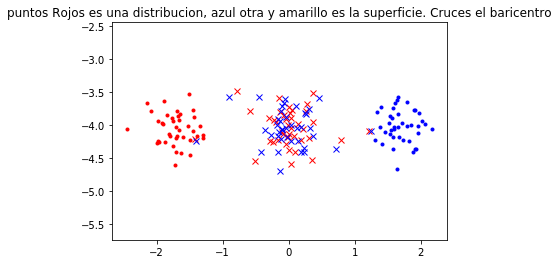

In [85]:
#plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:puntos,0],y[:puntos,1],'x',c='r')
plt.plot(y[puntos:,0],y[puntos:,1],'x',c='b')
plt.axis('equal')
plt.title('puntos Rojos es una distribucion, azul otra y amarillo es la superficie. Cruces el baricentro')
plt.show()

Si hacemos mas iteraciones todavía?

In [75]:
n=0
niter=5000
while (n<niter):
    learningrate=min(learningrate*2.01,learningrate0)
    
    cost,cost_grad=fermat_cost(y.flatten(),x,dimension,f_dist,tree,data,k,alpha)
    #cost,cost_grad=euclidean_cost(y.flatten(),x)
    
    
    grad_matrix=grad_matrix_y(y)
    f_grad=fgrad(y,grad_matrix,C)
    
    kernel_matrix=kernel_matrix_y(y)
    print(cost,(lagrangiano(landa,kernel_matrix,C,cost)-cost)/landa)
    
    
    beta=landa*0.001
    landamin=beta-landamin_actualizacion(cost_grad,f_grad)
    
    
    
    if(landamin>landa and landamin<landamax): 
        landa=landamin
    elif(landamin>landamax): 
        landa=landamax
    
    
    gradienteLagrangiano=lagrangiano_grad(landa,cost_grad,f_grad)
    yviejo=y
    costviejo=cost
    
    
    while(True):
        y=(yviejo.flatten()-(learningrate*gradienteLagrangiano)).reshape(yviejo.shape)  
        kernel_matrix=kernel_matrix_y(y) 
        
        cost,cost_grad=fermat_cost(y.flatten(),x,dimension,f_dist,tree,data,k,alpha)
        #cost,cost_grad=euclidean_cost(y.flatten(),x)
       
        lag_nuevo=lagrangiano(landa,kernel_matrix,C,cost)
        lag_viejo=lagrangiano(landa,kernel_matrix,C,costviejo)
        
        if(lag_nuevo<=(1+1/landa)*lag_viejo): 
            break #es que el lagrangiano nuevo disminuyo efectivamente (uso el y nuevo en ambos -kernel_matrix- pero el costo que a cada uno le corresponde)
        learningrate=learningrate/2             
      
    print("it: "+str(n)+", paso: "+str(learningrate*np.linalg.norm(gradienteLagrangiano))+", landa: "+str(landa))
    n=n+1       

17.10778734960036 0.00427316821455726
it: 0, paso: 0.0032830708412450852, landa: 97939.59948260766
17.11069411166521 0.004224330548385748
it: 1, paso: 0.003207814045376883, landa: 97939.59948260766
17.1135310578925 0.004177868342523146
it: 2, paso: 0.0031338338781098053, landa: 97939.59948260766
17.11629902793653 0.004133677012301611
it: 3, paso: 0.0030611205227932424, landa: 97939.59948260766
17.118998878178058 0.004091655988930246
it: 4, paso: 0.002989663972531218, landa: 97939.59948260766
17.12163148047488 0.004051708594596563
it: 5, paso: 0.002919454037985653, landa: 97939.59948260766
17.12419772094335 0.004013741920098532
it: 6, paso: 0.002850975812382013, landa: 97939.59948260766
17.12669850115421 0.003977661032673745
it: 7, paso: 0.0027832148686023897, landa: 97939.59948260766
17.129134768752888 0.003943386306771573
it: 8, paso: 0.0027166692166910107, landa: 97939.59948260766
17.131507444950255 0.003910835403857973
it: 9, paso: 0.0026513280121047873, landa: 97939.59948260766
17.

it: 81, paso: 0.0031173566139247157, landa: 99458.02057582929
16.811113265448007 0.003471228264116986
it: 82, paso: 0.0029998684064610134, landa: 99458.02057582929
16.814245824874003 0.003442774441456258
it: 83, paso: 0.002886221176959869, landa: 99458.02057582929
16.817252495559547 0.0034164261252941234
it: 84, paso: 0.0027763187300397286, landa: 99458.02057582929
16.820136851328808 0.0033920322113305803
it: 85, paso: 0.002670066469384919, landa: 99458.02057582929
16.82290242257362 0.0033694518556379163
it: 86, paso: 0.0025673714152104968, landa: 99458.02057582929
16.82555269306175 0.003348553830649421
it: 87, paso: 0.0024681422199706415, landa: 99458.02057582929
16.82809109705234 0.0033292159173404882
it: 88, paso: 0.0023722891824035615, landa: 99458.02057582929
16.830521016702445 0.0033113243318831655
it: 89, paso: 0.00227972425999781, landa: 99458.02057582929
16.832845779749324 0.00329477318511066
it: 90, paso: 0.0021903610799571573, landa: 99458.02057582929
16.835068657453608 0.00

it: 161, paso: 0.001348991008036103, landa: 106955.80146184759
16.777579054280455 0.003494967643252957
it: 162, paso: 0.001333671506288203, landa: 106955.80146184759
16.779536768088697 0.0034805985753484764
it: 163, paso: 0.0013184412915875964, landa: 106955.80146184759
16.781477789132765 0.003466589813385257
it: 164, paso: 0.0013033017209300687, landa: 106955.80146184759
16.78340212978707 0.0034529333414945415
it: 165, paso: 0.0012882541356892556, landa: 106955.80146184759
16.78530980506032 0.0034396212699845516
it: 166, paso: 0.00127329986138062, landa: 106955.80146184759
16.787200832571195 0.0034266458348678015
it: 167, paso: 0.0012584402074292133, landa: 106955.80146184759
16.78907523252321 0.0034139993973495517
it: 168, paso: 0.0012436764669411008, landa: 106955.80146184759
16.790933027678964 0.0034016744432779516
it: 169, paso: 0.0012290099164783473, landa: 106955.80146184759
16.792774243333508 0.0033896635825559317
it: 170, paso: 0.0012144418158375574, landa: 106955.80146184759


it: 240, paso: 0.003578764057043609, landa: 106955.80146184759
16.894054506870017 0.0027550613418253224
it: 241, paso: 0.005502912944768115, landa: 106955.80146184759
16.894684397728714 0.002750040063583426
it: 242, paso: 0.008082772596270658, landa: 107105.39643767412
16.889545820994694 0.002748931116580922
it: 243, paso: 0.014734479027437474, landa: 107298.47260413287
16.88071186085329 0.00274613366381851
it: 244, paso: 0.028711598005928117, landa: 107298.47260413287
16.88328527965277 0.0027229592328193377
it: 245, paso: 0.0936041536289356, landa: 107995.41845962364
16.790503990480648 0.003009968097201468
it: 246, paso: 0.001732328258215279, landa: 107995.41845962364
16.793133563654862 0.0029939665745714328
it: 247, paso: 0.0016951324305372632, landa: 107995.41845962364
16.79570412495237 0.0029786631994531206
it: 248, paso: 0.0016585326210514161, landa: 107995.41845962364
16.79821640623256 0.002964029842160675
it: 249, paso: 0.0016225252280662363, landa: 107995.41845962364
16.8006711

it: 319, paso: 0.0002809176580860967, landa: 116226.05647463477
16.917980323512158 0.002620785537881244
it: 320, paso: 0.00027980100000697645, landa: 116226.05647463477
16.919463884490213 0.0026191699418326012
it: 321, paso: 0.0002787719788417342, landa: 116226.05647463477
16.920920708152266 0.002617581308395718
it: 322, paso: 0.0002778273754498267, landa: 116226.05647463477
16.922351240946014 0.002616019077838458
it: 323, paso: 0.00027696404726855993, landa: 116226.05647463477
16.923755923381133 0.0026144827040543816
it: 324, paso: 0.00027617893065991266, landa: 116226.05647463477
16.92513519005323 0.0026129716541002704
it: 325, paso: 0.000550938085769433, landa: 116226.05647463477
16.927843929716275 0.0026100005383551147
it: 326, paso: 0.0005457135739226622, landa: 116226.05647463477
16.930440848947615 0.0026071411712941207
it: 327, paso: 0.000541109743980376, landa: 116226.05647463477
16.93293096737492 0.0026043879572233207
it: 328, paso: 0.0005370660674629392, landa: 116226.0564746

it: 398, paso: 0.0075200909959527214, landa: 116910.58686487883
16.807813173031562 0.00237264022087474
it: 399, paso: 0.01459079094299713, landa: 116910.76865902904
16.79261734995462 0.0023697918276972887
it: 400, paso: 0.028064788269734065, landa: 116910.76865902904
16.790611208302543 0.002342223499254067
it: 401, paso: 0.10268720149159036, landa: 118303.81076980468
16.666455433674496 0.0023911179234795063
it: 402, paso: 0.0008018276664740619, landa: 118303.81076980468
16.668547063838034 0.002386874380942813
it: 403, paso: 0.0007863700067771012, landa: 118303.81076980468
16.670567326891668 0.002382796948395403
it: 404, paso: 0.0007712480090779553, landa: 118303.81076980468
16.672517537147503 0.0023788797688448684
it: 405, paso: 0.0007564596740894115, landa: 118303.81076980468
16.674398998965845 0.002375117182229944
it: 406, paso: 0.0007420029888763166, landa: 118303.81076980468
16.676213006508195 0.002371503719229476
it: 407, paso: 0.000727875925312855, landa: 118303.81076980468
16.67

it: 477, paso: 0.0008804286219425591, landa: 122348.00694128363
16.484031560821848 0.0026438285483910318
it: 478, paso: 0.0008755890807551866, landa: 122348.00694128363
16.48615516930517 0.0026343081271267476
it: 479, paso: 0.0008707340461842801, landa: 122348.00694128363
16.488264266359398 0.0026249245718878945
it: 480, paso: 0.0008658639270793764, landa: 122348.00694128363
16.490358780005348 0.002615676681076003
it: 481, paso: 0.0008609791354553453, landa: 122348.00694128363
16.492438639557406 0.002606563251014168
it: 482, paso: 0.000856080086442453, landa: 122348.00694128363
16.49450377563966 0.0025975830761790658
it: 483, paso: 0.0008511671982354807, landa: 122348.00694128363
16.49655412020167 0.002588734949431087
it: 484, paso: 0.0008462408920420852, landa: 122348.00694128363
16.498589606534118 0.0025800176622445842
it: 485, paso: 0.0008413015920302762, landa: 122348.00694128363
16.50061016928435 0.0025714300049355845
it: 486, paso: 0.0008363497252750657, landa: 122348.00694128363

it: 556, paso: 0.0007499603658393647, landa: 122348.00694128363
16.617657084718193 0.002185392570619433
it: 557, paso: 0.0014665640339486155, landa: 122348.00694128363
16.61988266421244 0.0021801247717887044
it: 558, paso: 0.0013920157918698352, landa: 122348.00694128363
16.621891468062902 0.002175407191884245
it: 559, paso: 0.001321784407896678, landa: 122348.00694128363
16.623696080466406 0.0021711884255439713
it: 560, paso: 0.0012556771693342992, landa: 122348.00694128363
16.625308529669173 0.0021674219149041963
it: 561, paso: 0.0011935099903936607, landa: 122348.00694128363
16.62674030481325 0.002164065480270266
it: 562, paso: 0.0011351069424178194, landa: 122348.00694128363
16.628002372748032 0.0021610808964496685
it: 563, paso: 0.0021605995526741066, landa: 122348.00694128363
16.630209176190593 0.0021558877447852326
it: 564, paso: 0.0019455600124350903, landa: 122348.00694128363
16.63180590758501 0.0021518963494310144
it: 565, paso: 0.003527780999717716, landa: 122348.00694128363

16.563626827885066 0.00206086267115592
it: 636, paso: 0.0030082126202465903, landa: 125332.30167012483
16.565167661104518 0.002055377383986984
it: 637, paso: 0.0023795813825683064, landa: 125332.30167012483
16.566293237112752 0.0020518867449877205
it: 638, paso: 0.0037772880902224425, landa: 125332.30167012483
16.56791048292464 0.002047850781923145
it: 639, paso: 0.004518799398447297, landa: 125332.30167012483
16.569178516295135 0.0020455659511559227
it: 640, paso: 0.003912905214458684, landa: 125503.14097180922
16.56949180013323 0.0020445289084019326
it: 641, paso: 0.007695335745132431, landa: 125581.59750940005
16.569749059446476 0.0020424719587942234
it: 642, paso: 0.016680114890575762, landa: 125589.70488854931
16.57108884589676 0.0020416595471810517
it: 643, paso: 0.10233815654798449, landa: 125589.70488854931
16.516369478502185 0.0025584506404293145
it: 644, paso: 0.0025518928713494154, landa: 125589.70488854931
16.517846717820333 0.0025295778649246834
it: 645, paso: 0.0024915358

it: 716, paso: 0.003918669722582293, landa: 128530.40891829666
16.588217905331977 0.0019732081849292106
it: 717, paso: 0.004426062253692996, landa: 128530.40891829666
16.590044600565875 0.001971713381318367
it: 718, paso: 0.011420738747990954, landa: 128705.22242783524
16.58908481997195 0.0019735245517759404
it: 719, paso: 0.002526511308517237, landa: 128705.22242783524
16.590532661025417 0.0019707390840556236
it: 720, paso: 0.0034108038678507743, landa: 128705.22242783524
16.592249413054 0.0019683593358371687
it: 721, paso: 0.0027224041684126, landa: 128720.10964991733
16.592812853420288 0.001967827472009655
it: 722, paso: 0.003832086184358867, landa: 128898.47863657541
16.59383337784923 0.001966372829814103
it: 723, paso: 0.00445313093905906, landa: 128898.47863657541
16.595550330740913 0.001965035849675514
it: 724, paso: 0.012172361267398287, landa: 129066.38524498558
16.594171034029102 0.001968008566128712
it: 725, paso: 0.0029300316013263243, landa: 129066.38524498558
16.595854224

it: 796, paso: 0.002673560736579089, landa: 133932.2934602112
16.669368212111248 0.0018776527993237988
it: 797, paso: 0.0026605658056676348, landa: 134000.1781474046
16.670526925804893 0.0018765112858235018
it: 798, paso: 0.0026480031791235605, landa: 134072.96053711054
16.671687584590103 0.0018753644687344994
it: 799, paso: 0.0026353688301122423, landa: 134141.2963162731
16.6728739499078 0.0018742122135759038
it: 800, paso: 0.0026232271073114554, landa: 134215.54506103005
16.67405938280847 0.0018730546349893602
it: 801, paso: 0.002610943522517737, landa: 134284.13597167723
16.67527362058573 0.0018718915745476997
it: 802, paso: 0.0025992592188463673, landa: 134360.10343224896
16.676482693058425 0.0018707231913253955
it: 803, paso: 0.002587352202915636, landa: 134428.62393328003
16.67772534245061 0.0018695492966786798
it: 804, paso: 0.0025762395670121314, landa: 134506.7251289563
16.678956423516727 0.0018683701241678824
it: 805, paso: 0.0025648255950235883, landa: 134574.64381909577
16.

it: 876, paso: 0.0022695532068131704, landa: 139634.0757338787
16.769806091949288 0.0017818840255540173
it: 877, paso: 0.001456818476015028, landa: 139669.44976604
16.77084048684917 0.0017811166583897777
it: 878, paso: 0.002443603062796085, landa: 139801.18056634613
16.772429080672104 0.001779549153400139
it: 879, paso: 0.00180321887654018, landa: 139801.18056634613
16.773483190510053 0.0017788169806778394
it: 880, paso: 0.002821073185965343, landa: 139963.03929151385
16.774883247464693 0.0017773590412628016
it: 881, paso: 0.002456448802420095, landa: 139963.03929151385
16.776439810292082 0.0017763138232975808
it: 882, paso: 0.003625838372565444, landa: 140159.06093781762
16.777414262436228 0.0017751634122013886
it: 883, paso: 0.0018343037048307413, landa: 140159.06093781762
16.77871260440001 0.0017740998585855372
it: 884, paso: 0.0011665618787421142, landa: 140251.50314985923
16.779772875812586 0.0017732588037895956
it: 885, paso: 0.002196383381816238, landa: 140349.99046979114
16.781

it: 955, paso: 0.0012600530953465379, landa: 145676.72431801184
16.866777789980592 0.0016995518841870943
it: 956, paso: 0.00150675139913794, landa: 145821.65326492925
16.867949579402868 0.0016984195116005992
it: 957, paso: 0.0019538536891158106, landa: 145821.65326492925
16.869697202506963 0.0016972719614648819
it: 958, paso: 0.005533662748363359, landa: 146014.45805623507
16.870810101888072 0.0016964674826886895
it: 959, paso: 0.0026523275959328646, landa: 146014.45805623507
16.87248994176377 0.0016946462607436094
it: 960, paso: 0.0019695896611479713, landa: 146014.45805623507
16.87330736031505 0.0016941223727982115
it: 961, paso: 0.0015158559578368148, landa: 146226.12225002795
16.874519587833415 0.0016929637664672176
it: 962, paso: 0.0020373857021029514, landa: 146226.12225002795
16.876211740528614 0.001691878740981939
it: 963, paso: 0.006050795711351047, landa: 146417.98471108836
16.87713951803984 0.0016913886825176353
it: 964, paso: 0.0015197341769516005, landa: 146417.98471108836

it: 1034, paso: 0.0008489197172809734, landa: 152132.94977336496
16.96158250602916 0.001621465579575598
it: 1035, paso: 0.0008483980288397317, landa: 152214.61397300125
16.962630216939324 0.0016205932782861728
it: 1036, paso: 0.000846765460540605, landa: 152285.14755140417
16.963708172516167 0.001619716752252436
it: 1037, paso: 0.0008463505782734017, landa: 152367.02511703904
16.964769621094607 0.0016188361811705174
it: 1038, paso: 0.0008448722074392755, landa: 152438.71282408727
16.96585989613976 0.0016179513671775129
it: 1039, paso: 0.0008445501738854006, landa: 152521.09283133326
16.966934640916612 0.0016170624767120024
it: 1040, paso: 0.0008431758329927746, landa: 152593.7016476783
16.968037841674413 0.001616169317981727
it: 1041, paso: 0.0008429598217701777, landa: 152676.83408945752
16.969125486683144 0.001615272054030848
it: 1042, paso: 0.0008416653536761723, landa: 152750.1535271563
16.970242195398434 0.0016143704922999768
it: 1043, paso: 0.0008415932943524757, landa: 152834.28

it: 1113, paso: 0.0008597155409933687, landa: 158718.80394695635
17.05488473905719 0.0015477391172354154
it: 1114, paso: 0.0012528893499265635, landa: 158825.50391645252
17.05583057891168 0.0015471208829800688
it: 1115, paso: 0.0011017798142274576, landa: 158877.10834880592
17.056708748193167 0.0015464883238102715
it: 1116, paso: 0.0010654564584667398, landa: 158877.10834880592
17.05771867950276 0.0015458031028157662
it: 1117, paso: 0.0010487669591248674, landa: 158914.38817810352
17.05865323824886 0.0015451621386446627
it: 1118, paso: 0.0010386752846515798, landa: 158953.0179015463
17.05960709633354 0.0015445178458440706
it: 1119, paso: 0.0010318170655041618, landa: 159003.46229065026
17.060563017912337 0.0015438703941700175
it: 1120, paso: 0.0010262514166356985, landa: 159054.8260288649
17.06152758856524 0.0015432197640105174
it: 1121, paso: 0.0010215418156514498, landa: 159109.87009956903
17.062495623547154 0.001542565979756194
it: 1122, paso: 0.001017293789546739, landa: 159165.650

it: 1192, paso: 0.0008694152935100546, landa: 164291.68746819938
17.14246996691682 0.0014871882728965538
it: 1193, paso: 0.0008675668267660827, landa: 164382.54913666812
17.14378926658209 0.0014862680578272684
it: 1194, paso: 0.0008657181831242711, landa: 164473.97424593414
17.145114825425527 0.0014853435270118264
it: 1195, paso: 0.000863869487003241, landa: 164565.9661920095
17.14644667916681 0.001484414662031501
it: 1196, paso: 0.0008620207793041918, landa: 164658.52761675356
17.147784865754193 0.0014834814443975889
it: 1197, paso: 0.0008601722382135201, landa: 164751.662243265
17.149129420673518 0.001482543855567258
it: 1198, paso: 0.0008583238775214225, landa: 164845.3724031711
17.150480383337616 0.001481601876921214
it: 1199, paso: 0.0008564759619028922, landa: 164939.66240499794
17.151837788317795 0.00148065548979448
it: 1200, paso: 0.0008546284287277002, landa: 165034.53390489955
17.153201677512723 0.0014797046754345964
it: 1201, paso: 0.0008527817000351198, landa: 165129.992335

it: 1271, paso: 0.000639961015256638, landa: 170159.6066566342
17.225687893910326 0.001429603261527003
it: 1272, paso: 0.000639516499712367, landa: 170231.50499856388
17.226634339224383 0.0014289337115092606
it: 1273, paso: 0.0006390646381579377, landa: 170303.81846682582
17.22758579056331 0.0014282609792988206
it: 1274, paso: 0.0006386055221898145, landa: 170376.549380339
17.2285422756669 0.0014275850506802977
it: 1275, paso: 0.0006381392465458029, landa: 170449.7000872086
17.229503822242606 0.0014269059113836584
it: 1276, paso: 0.0006376659086859429, landa: 170523.2729526972
17.23047045798169 0.0014262235470833644
it: 1277, paso: 0.000637185609449809, landa: 170597.27036697997
17.231442210564865 0.00142553794339891
it: 1278, paso: 0.0006366984527803332, landa: 170671.69474221746
17.232419107673984 0.0014248490858945126
it: 1279, paso: 0.0006362045459024027, landa: 170746.5485147787
17.23340117699891 0.0014241569600790206
it: 1280, paso: 0.0006357039992162447, landa: 170821.8341442058

it: 1350, paso: 0.0014612089575697764, landa: 176215.8223007939
17.307644815782407 0.0013675308867694186
it: 1351, paso: 0.0019965726304255714, landa: 176380.89991111375
17.30877773873714 0.0013666025060049619
it: 1352, paso: 0.0011624057931625715, landa: 176380.89991111375
17.30958698555185 0.0013660713572887584
it: 1353, paso: 0.0019053060202873654, landa: 176519.42927834045
17.31080883399427 0.0013651072300233519
it: 1354, paso: 0.0020529302551253615, landa: 176556.1022849689
17.312213638140538 0.0013641767619672796
it: 1355, paso: 0.002501709697944133, landa: 176746.0036161042
17.31309942800284 0.001363370793840672
it: 1356, paso: 0.0018039919026528318, landa: 176746.0036161042
17.314445341031668 0.00136252729822345
it: 1357, paso: 0.0022219766534788466, landa: 176945.5987513467
17.315494071354323 0.0013616309424738877
it: 1358, paso: 0.001491232016682314, landa: 176945.5987513467
17.316656232696968 0.0013609009333642918
it: 1359, paso: 0.0020711140258263348, landa: 177122.65083124

it: 1429, paso: 0.0017352142170769906, landa: 182893.68848283187
17.376447754263562 0.0013030952744531356
it: 1430, paso: 0.0017356514306725666, landa: 182946.14873904554
17.37720440906295 0.0013023918787035049
it: 1431, paso: 0.0017381009415761458, landa: 183042.2407835755
17.377936897815847 0.0013016857217829825
it: 1432, paso: 0.0017394670889173834, landa: 183094.67064508662
17.378716352285796 0.0013009763676172241
it: 1433, paso: 0.0017434358378702918, landa: 183195.14405018842
17.37946411846416 0.0013002645520660105
it: 1434, paso: 0.0017465679014421842, landa: 183243.1670904343
17.38026770756798 0.0012995498742691353
it: 1435, paso: 0.0017537181721565794, landa: 183351.3690622692
17.381025653564567 0.0012988334206730106
it: 1436, paso: 0.001760806206893534, landa: 183390.72335347853
17.381851409915125 0.0012981149138356124
it: 1437, paso: 0.0017749375910796265, landa: 183510.62630296368
17.38260920983596 0.0012973961915291334
it: 1438, paso: 0.00179145481491701, landa: 183535.025

it: 1508, paso: 0.0018053272069420143, landa: 189623.92036198487
17.451648840025953 0.0012449372702207175
it: 1509, paso: 0.00266976828711053, landa: 189875.82891831003
17.452671025471087 0.0012441538038856733
it: 1510, paso: 0.001195015408171717, landa: 189875.82891831003
17.453586490188226 0.0012435354042577593
it: 1511, paso: 0.0009967555314943492, landa: 189960.1834745859
17.45435291321525 0.0012430295694773957
it: 1512, paso: 0.0009526796253819211, landa: 190077.625064243
17.455070223130832 0.001242515677043822
it: 1513, paso: 0.0009327196167039185, landa: 190104.68451881406
17.45584079445727 0.0012419965414974992
it: 1514, paso: 0.0009267550705913835, landa: 190194.50706796665
17.456589042920378 0.0012414741300745622
it: 1515, paso: 0.0009241474879055439, landa: 190244.36310661785
17.457362461361953 0.0012409486092387835
it: 1516, paso: 0.0009247559326640237, landa: 190322.49970985338
17.45812777807843 0.0012404204811600533
it: 1517, paso: 0.0009255451510119293, landa: 190382.579

it: 1587, paso: 0.0016416713473272127, landa: 195812.27559051974
17.525975534903314 0.0011966808848452813
it: 1588, paso: 0.0018166170643483372, landa: 196013.23710677933
17.526954859204462 0.0011960045750804514
it: 1589, paso: 0.001077539768098688, landa: 196013.23710677933
17.527828969457573 0.0011954952200529452
it: 1590, paso: 0.0015486186855514885, landa: 196164.0834322762
17.528969122677367 0.0011947544543810167
it: 1591, paso: 0.001613760486033078, landa: 196197.9334231712
17.530207489349337 0.0011940229659146353
it: 1592, paso: 0.001772683182067067, landa: 196389.4723173943
17.531245214801633 0.001193321815564301
it: 1593, paso: 0.0010514898485126413, landa: 196389.4723173943
17.532071286414496 0.001192842306473301
it: 1594, paso: 0.0015582545255897076, landa: 196542.22642641445
17.5332402507372 0.0011920884012837044
it: 1595, paso: 0.001639576138816708, landa: 196576.80993786862
17.534509492941584 0.001191347143800512
it: 1596, paso: 0.0018464042815788603, landa: 196776.667550

it: 1666, paso: 0.000849195613749871, landa: 201779.99247406365
17.59098051591769 0.0011571776110060104
it: 1667, paso: 0.000850297663098848, landa: 201863.75515698924
17.5918601203597 0.0011566354510227541
it: 1668, paso: 0.0008513838803355728, landa: 201948.01443793555
17.59274474270365 0.0011560907193798623
it: 1669, paso: 0.0008524541367580962, landa: 202032.77336173324
17.593634409632283 0.0011555434046450772
it: 1670, paso: 0.0008535083056544883, landa: 202118.03498700532
17.59452914796591 0.001154993495342616
it: 1671, paso: 0.0008545462625453656, landa: 202203.80238955727
17.595428984663872 0.0011544409799543478
it: 1672, paso: 0.0008555678853904259, landa: 202290.07866490455
17.59633394682216 0.001153885846918542
it: 1673, paso: 0.0008565730545629816, landa: 202376.86692604978
17.59724406167557 0.0011533280846308725
it: 1674, paso: 0.0008575616531093127, landa: 202464.17030696973
17.59815935659526 0.0011527676814434098
it: 1675, paso: 0.0008585335666923025, landa: 202551.99195

it: 1745, paso: 0.0004937226598796425, landa: 208542.2356778581
17.661482816266908 0.0011150450105115936
it: 1746, paso: 0.000494860429978102, landa: 208607.87424354107
17.662158238334356 0.00111465080672947
it: 1747, paso: 0.0004959954807023988, landa: 208673.88164894257
17.662837253418417 0.0011142547084353153
it: 1748, paso: 0.0004971277875808524, landa: 208740.26016657302
17.663519880908424 0.0011138567069355636
it: 1749, paso: 0.0004982573259772208, landa: 208807.01206804605
17.66420614026637 0.0011134567935008454
it: 1750, paso: 0.000499384071377013, landa: 208874.13962644504
17.66489605102933 0.0011130549593665272
it: 1751, paso: 0.0005005079995126885, landa: 208941.64511925515
17.66558963281107 0.0011126511957320166
it: 1752, paso: 0.0005016290864207599, landa: 209009.53082971094
17.666286905303497 0.0011122454937608226
it: 1753, paso: 0.0005027473085004414, landa: 209077.7990481242
17.66698788827792 0.001111837844580562
it: 1754, paso: 0.0005038626425655833, landa: 209146.4520

it: 1824, paso: 0.0005742872968352281, landa: 215061.8130297695
17.727575014668993 0.001077322828564842
it: 1825, paso: 0.0005751950791015458, landa: 215164.65545621442
17.728601099603797 0.0010767492187072688
it: 1826, paso: 0.0005761010074687356, landa: 215268.09411788665
17.72963259841466 0.0010761729107195272
it: 1827, paso: 0.0005770051486335018, landa: 215372.13279984312
17.73066953860724 0.001075593892832791
it: 1828, paso: 0.0005779075709731455, landa: 215476.77531631096
17.731711947819132 0.0010750121532372267
it: 1829, paso: 0.0005788083445466217, landa: 215582.02551095138
17.732759853820635 0.0010744276800815546
it: 1830, paso: 0.0005797075410947025, landa: 215687.88725717546
17.733813284515787 0.001073840461472923
it: 1831, paso: 0.0005806052340408205, landa: 215794.36445839747
17.734872267943295 0.001073250485477201
it: 1832, paso: 0.0005815014984936909, landa: 215901.46104839063
17.735936832277368 0.0010726577401185156
it: 1833, paso: 0.0005823964112402123, landa: 216009.

it: 1902, paso: 0.0008111142431743536, landa: 221071.3342287153
17.787872340888928 0.0010439015299303512
it: 1903, paso: 0.0008065971654910077, landa: 221189.87152883076
17.7885615569919 0.0010434855271757384
it: 1904, paso: 0.0008031422875305916, landa: 221290.66548605403
17.78925559966567 0.0010430675123332307
it: 1905, paso: 0.0008003207232283524, landa: 221381.70073828532
17.789953913508956 0.001042647485279729
it: 1906, paso: 0.0007978859886941079, landa: 221466.37659898837
17.790655128032032 0.0010422254377090764
it: 1907, paso: 0.0007956731422262727, landa: 221545.77905997494
17.79135978306768 0.0010418013559515878
it: 1908, paso: 0.0007936430656779664, landa: 221622.35353627024
17.79206743268531 0.001041375231879941
it: 1909, paso: 0.0007917314546349386, landa: 221696.40724936133
17.79277867919176 0.0010409470528606377
it: 1910, paso: 0.0007899343790221825, landa: 221769.28411937578
17.793493466569355 0.0010405168102048282
it: 1911, paso: 0.000788222310513039, landa: 221841.100

it: 1981, paso: 0.00037419751754127974, landa: 228109.80350716427
17.854981404468848 0.001005287959911896
it: 1982, paso: 0.0003750403200506816, landa: 228169.840116235
17.855534170848017 0.0010049849996866306
it: 1983, paso: 0.0003758792659133178, landa: 228228.37229963086
17.856090300658416 0.0010046805697497318
it: 1984, paso: 0.0003767431460527386, landa: 228287.7753161501
17.856649361618864 0.0010043746674126362
it: 1985, paso: 0.0003776009562794381, landa: 228347.33833345585
17.85721150830435 0.0010040672846466404
it: 1986, paso: 0.0003784604703521878, landa: 228407.28822683627
17.857776713037445 0.001003758414930826
it: 1987, paso: 0.0003793191067835102, landa: 228467.55866659712
17.858345006407482 0.001003448051226404
it: 1988, paso: 0.0003801777644002733, landa: 228528.176143297
17.85891640018742 0.0010031361866230278
it: 1989, paso: 0.00038103620154074635, landa: 228589.13645166677
17.859490912526578 0.0010028228141311195
it: 1990, paso: 0.00038189454921096753, landa: 228650.

it: 2059, paso: 0.000441556580431695, landa: 233864.83891393465
17.908487893802413 0.0009766906052394995
it: 2060, paso: 0.000442440163760458, landa: 233956.88682889965
17.90932937444012 0.0009762504354441937
it: 2061, paso: 0.0004433248513036462, landa: 234049.47672807952
17.91017535361384 0.0009758081734773137
it: 2062, paso: 0.0004442106777133979, landa: 234142.6120031897
17.91102585375813 0.0009753638100100947
it: 2063, paso: 0.00044509767832839273, landa: 234236.2960705245
17.911880897408516 0.0009749173356786949
it: 2064, paso: 0.00044598588917630223, landa: 234330.53237118587
17.912740507202162 0.0009744687410845599
it: 2065, paso: 0.00044687534698070644, landa: 234425.32437127168
17.913604705878555 0.0009740180167939339
it: 2066, paso: 0.0004477660891650919, landa: 234520.6755621066
17.91447351628024 0.0009735651533381634
it: 2067, paso: 0.00044865815385621173, landa: 234616.589460437
17.915346961353592 0.0009731101412134514
it: 2068, paso: 0.0004495515798904992, landa: 234713.

it: 2137, paso: 0.0002721838954640256, landa: 240522.3739825053
17.96756000858081 0.0009462967720289642
it: 2138, paso: 0.00027311112126601034, landa: 240594.31266955807
17.968189276096002 0.0009459775399721817
it: 2139, paso: 0.0002740409050809701, landa: 240666.65276955423
17.968821776377172 0.0009456567723266051
it: 2140, paso: 0.0002749732603915025, landa: 240739.39669989058
17.969457525949743 0.0009453344620336308
it: 2141, paso: 0.0002759082008963659, landa: 240812.54689406845
17.970096541423015 0.0009450106020059176
it: 2142, paso: 0.00027684574051303507, landa: 240886.10580184116
17.970738839490608 0.0009446851851268379
it: 2143, paso: 0.0002777858933829144, landa: 240960.07588933152
17.971384436930897 0.0009443582042510208
it: 2144, paso: 0.00027872867387211084, landa: 241034.45963918776
17.972033350607514 0.0009440296522033844
it: 2145, paso: 0.00027967409657720277, landa: 241109.25955072022
17.972685597469813 0.0009436995217803599
it: 2146, paso: 0.0002806221763262601, landa

it: 2215, paso: 0.0011629958801513728, landa: 247773.8115062403
18.024944734270584 0.000916330802366282
it: 2216, paso: 0.0006902051962579139, landa: 247773.8115062403
18.025615323463082 0.0009160022842529829
it: 2217, paso: 0.0007161928048335548, landa: 247926.06722553563
18.026468470605053 0.0009155401384805167
it: 2218, paso: 0.0007294932795347174, landa: 247997.9801563778
18.02736915168349 0.0009150768990392903
it: 2219, paso: 0.0007577317993082763, landa: 248165.51876032792
18.02821626849678 0.0009146141010579176
it: 2220, paso: 0.0007988852976189874, landa: 248213.3685196183
18.02913333124241 0.0009141530111580695
it: 2221, paso: 0.0008773223464498113, landa: 248411.6568911892
18.029947683643545 0.0009136980397719671
it: 2222, paso: 0.000998597818482497, landa: 248411.6568911892
18.03090633854059 0.0009132373925876094
it: 2223, paso: 0.001206769391316765, landa: 248662.62164768804
18.031609171659245 0.0009128213557002004
it: 2224, paso: 0.0007627969867494356, landa: 248662.621647

it: 2293, paso: 0.0004228620121684744, landa: 254227.6501585748
18.07497951595549 0.0008909021223831129
it: 2294, paso: 0.0004239495567406503, landa: 254314.4110719308
18.075659488145345 0.0008905669255200527
it: 2295, paso: 0.00042503568692678855, landa: 254401.64616151102
18.076343145185962 0.0008902301276408608
it: 2296, paso: 0.0004261203900164606, landa: 254489.3585166142
18.077030505669637 0.0008898917214776473
it: 2297, paso: 0.00042720365392475183, landa: 254577.55124118685
18.0777215882951 0.0008895516997340367
it: 2298, paso: 0.0004282854672090365, landa: 254666.22745409614
18.07841641186764 0.0008892100550848157
it: 2299, paso: 0.00042936581908197387, landa: 254755.39028940088
18.079114995299086 0.0008888667801757252
it: 2300, paso: 0.00043044469942769966, landa: 254845.04289661365
18.07981682089322 0.0008885218676240428
it: 2301, paso: 0.000431522086342897, landa: 254935.18088057582
18.080515429517845 0.0008881753100177215
it: 2302, paso: 0.00043259781997887837, landa: 2550

it: 2371, paso: 0.0003100640537034215, landa: 260984.49468777757
18.130339124474332 0.0008644187630141839
it: 2372, paso: 0.00031107185869133863, landa: 261050.06818089102
18.13085713332846 0.0008641754045999154
it: 2373, paso: 0.00031208123969837863, landa: 261116.00851408145
18.131377747797327 0.0008639308689527526
it: 2374, paso: 0.00031309218730122613, landa: 261182.31785063157
18.131900982577744 0.0008636851505979207
it: 2375, paso: 0.0003141046914263513, landa: 261248.9983366731
18.132426852420316 0.0008634382440373209
it: 2376, paso: 0.00031511874145807726, landa: 261316.05210567857
18.13295537213084 0.0008631901437495029
it: 2377, paso: 0.00031613432633245247, landa: 261383.4812822648
18.13348655657172 0.0008629408441896866
it: 2378, paso: 0.0003171514346159414, landa: 261451.28798552603
18.134020420663017 0.0008626903397895896
it: 2379, paso: 0.00031817005457538224, landa: 261519.47433185685
18.134556979383472 0.000862438624957125
it: 2380, paso: 0.0003191901742378081, landa: 

it: 2449, paso: 0.00039261582504804027, landa: 267375.2792552504
18.179776764760305 0.0008414502139947099
it: 2450, paso: 0.0003937194157429149, landa: 267476.6719843845
18.180547091477692 0.0008410967091129367
it: 2451, paso: 0.0003948241643985085, landa: 267578.6376447401
18.18132137460339 0.0008407415242761251
it: 2452, paso: 0.0003959300811123329, landa: 267681.1797243692
18.18209963467138 0.0008403846519730104
it: 2453, paso: 0.00039703717658360254, landa: 267784.30173786747
18.182881892314022 0.0008400260846640159
it: 2454, paso: 0.0003981454621222773, landa: 267888.0072265731
18.183668168262642 0.0008396658147804357
it: 2455, paso: 0.0003992549496558805, landa: 267992.2997587759
18.184458483348436 0.0008393038347253566
it: 2456, paso: 0.00040036565173845776, landa: 268097.1829299193
18.185252858503095 0.0008389401368728475
it: 2457, paso: 0.00040147758155684887, landa: 268202.6603628065
18.186051314759528 0.0008385747135683883
it: 2458, paso: 0.0004025907529409754, landa: 268308

it: 2527, paso: 0.0002613801294089322, landa: 273749.0341173616
18.22874656706025 0.0008192992239904488
it: 2528, paso: 0.0002621565128105218, landa: 273826.764918174
18.229321241722754 0.0008190422007343449
it: 2529, paso: 0.0002629397044224735, landa: 273904.9679008876
18.229898780179493 0.0008187839402626024
it: 2530, paso: 0.00026372955250843997, landa: 273983.6430928035
18.230479198658482 0.0008185244369169267
it: 2531, paso: 0.00026452591407326195, landa: 274062.79066800466
18.23106251347528 0.0008182636850128959
it: 2532, paso: 0.00026532865433244094, landa: 274142.41094032384
18.231648741030778 0.0008180016788413184
it: 2533, paso: 0.0002661376462177682, landa: 274222.5043567794
18.232237897809217 0.0008177384126673923
it: 2534, paso: 0.00026695276991906843, landa: 274303.0714914654
18.232830000376417 0.0008174738807314664
it: 2535, paso: 0.00026777391245247183, landa: 274384.113039833
18.233425065378068 0.0008172080772482678
it: 2536, paso: 0.000268600967260471, landa: 274465.

it: 2605, paso: 0.00033734874983202027, landa: 281359.79284318275
18.28351237737268 0.0007950691745817869
it: 2606, paso: 0.00033850452510046674, landa: 281480.6202968834
18.284364819980496 0.000794696705977861
it: 2607, paso: 0.00033966504745040917, landa: 281602.13338689145
18.285221617389517 0.0007943224811826638
it: 2608, paso: 0.0001704151693316435, landa: 281724.33644232573
18.28565219595702 0.0007941344709733532
it: 2609, paso: 0.000171135701684506, landa: 281785.8338340521
18.2860850506847 0.0007939455068012723
it: 2610, paso: 0.00017185761438633343, landa: 281847.6327837507
18.286520092656083 0.0007937556251593219
it: 2611, paso: 0.000172582186118719, landa: 281909.7576648685
18.286957333611348 0.0007935648217473902
it: 2612, paso: 0.00017330951636484058, landa: 281972.21288232907
18.287396784795554 0.0007933730922353448
it: 2613, paso: 0.00017403963435060028, landa: 282035.0008592565
18.287838457453017 0.0007931804322728358
it: 2614, paso: 0.0001747725588068006, landa: 282098

it: 2683, paso: 0.00023288847171299397, landa: 287386.5120539407
18.325013208308693 0.0007771010458447406
it: 2684, paso: 0.0002338519708181096, landa: 287478.67524192773
18.325645231531798 0.000776829956810225
it: 2685, paso: 0.00023481932187432915, landa: 287571.34594520275
18.32628045548292 0.0007765575703155465
it: 2686, paso: 0.000235790543827063, landa: 287664.5272046708
18.326918896442788 0.0007762838804578953
it: 2687, paso: 0.00023676565578771818, landa: 287758.22208194743
18.32756057077562 0.000776008881310672
it: 2688, paso: 0.00023774467703871217, landa: 287852.433659493
18.32820549492967 0.000775732566923808
it: 2689, paso: 0.00023872762703410521, landa: 287947.1650408207
18.32885368543753 0.0007754549313233966
it: 2690, paso: 0.0002397145254027814, landa: 288042.4193506353
18.32950515891683 0.0007751759685117755
it: 2691, paso: 0.0002407053919491825, landa: 288138.1997350209
18.330159932070504 0.0007748956724675112
it: 2692, paso: 0.00024170024665506318, landa: 288234.509

it: 2761, paso: 0.00017594112931715376, landa: 294251.8164562027
18.37422853724615 0.0007558149251629008
it: 2762, paso: 0.00017645261429381196, landa: 294321.87667818635
18.37469406043405 0.0007556178374720819
it: 2763, paso: 0.00017697061934243198, landa: 294392.37265421153
18.37516211533523 0.0007554197957994237
it: 2764, paso: 0.00017749509473246315, landa: 294463.30476894265
18.375632710613914 0.0007552207957254566
it: 2765, paso: 0.00017802599292941906, landa: 294534.67347069184
18.37610585501462 0.0007550208328109313
it: 2766, paso: 0.0001785632685334184, landa: 294606.4792712058
18.376581557364613 0.0007548199025968141
it: 2767, paso: 0.00017910687821498755, landa: 294678.7227452685
18.37705982657629 0.0007546180006043983
it: 2768, paso: 0.0001796567806507207, landa: 294751.4045301802
18.377540671649275 0.0007544151223350069
it: 2769, paso: 0.00018021293645810997, landa: 294824.525325106
18.378024101672473 0.0007542112632702367
it: 2770, paso: 0.00018077530813102017, landa: 294

it: 2839, paso: 0.0002336747329768531, landa: 301129.96516693674
18.418941052425357 0.0007372119657538021
it: 2840, paso: 0.00023464372687515835, landa: 301238.9989969059
18.419637682837852 0.0007369256293724243
it: 2841, paso: 0.00023561866073100617, landa: 301348.6380056964
18.42033782942856 0.0007366379314830411
it: 2842, paso: 0.00023659954782711442, landa: 301458.8857190705
18.421041509195984 0.000736348865984069
it: 2843, paso: 0.00023758640174110154, landa: 301569.7456924727
18.421748739255737 0.0007360584267497434
it: 2844, paso: 0.00023857923634444192, landa: 301681.2215111185
18.42245953684089 0.0007357666076317238
it: 2845, paso: 0.00023957806580131855, landa: 301793.31679005007
18.423173919302336 0.0007354734024572829
it: 2846, paso: 0.00024058290456496753, landa: 301906.0351742152
18.42389190410916 0.0007351788050300523
it: 2847, paso: 0.000241593767379071, landa: 302019.380338559
18.424613508848978 0.0007348828091305466
it: 2848, paso: 0.0002426106692723873, landa: 302133

it: 2917, paso: 0.00017111663303755593, landa: 307902.57560436666
18.461763565007374 0.0007197574877935158
it: 2918, paso: 0.000171494405079437, landa: 307979.2500856285
18.462278378801642 0.0007195492682641446
it: 2919, paso: 0.0001719030385065008, landa: 308056.79976549285
18.46279577317235 0.0007193400419986198
it: 2920, paso: 0.00017234034042475622, landa: 308135.1977952337
18.463315765204577 0.0007191298045915482
it: 2921, paso: 0.00017280437964003431, landa: 308214.4200259898
18.463838371148437 0.0007189185516036906
it: 2922, paso: 0.00017329342925826054, landa: 308294.4443703552
18.464363606678404 0.000718706278562807
it: 2923, paso: 0.00017380594103112276, landa: 308375.2507168944
18.46489148701907 0.000718492980964751
it: 2924, paso: 0.00017434051605191676, landa: 308456.8206591272
18.465422027077604 0.0007182786542744366
it: 2925, paso: 0.0001748958861735583, landa: 308539.13737568434
18.46595524152486 0.000718063293926832
it: 2926, paso: 0.00017547089653109502, landa: 308622

it: 2995, paso: 0.0002386758726281704, landa: 315876.01748976874
18.51081712496526 0.0007001196453114191
it: 2996, paso: 0.0001199098581917709, landa: 316003.7874134843
18.511198266946163 0.0006999686526292868
it: 2997, paso: 0.0001204991926517959, landa: 316068.08335703524
18.511581411188168 0.0006998168952298881
it: 2998, paso: 0.00012108994830282325, landa: 316132.6913395086
18.51196648439329 0.0006996644001841582
it: 2999, paso: 0.0001216834670893193, landa: 316197.6382344011
18.512353496850285 0.0006995111640262324
it: 3000, paso: 0.00012227984615260687, landa: 316262.92834573827
18.51274245847315 0.0006993571832652132
it: 3001, paso: 0.0001228791186396262, landa: 316328.56415107584
18.513133379168508 0.0006992024543943222
it: 3002, paso: 0.00012348130660408093, landa: 316394.54781834205
18.513526268885933 0.000699046973891193
it: 3003, paso: 0.00012408642914222596, landa: 316460.88143916725
18.513921137627424 0.0006988907382184413
it: 3004, paso: 0.00012469450422282125, landa: 31

18.546575013903038 0.0006860678589869409
it: 3073, paso: 0.00017472220234646, landa: 322105.9123355951
18.54713663112527 0.0006858489906702031
it: 3074, paso: 0.00017557874998812707, landa: 322202.9675249224
18.547701086253667 0.000685629073153182
it: 3075, paso: 0.00017643951190338215, landa: 322300.55145813926
18.548268393759205 0.0006854081016424004
it: 3076, paso: 0.00017730450942228694, landa: 322398.6672414469
18.54883856818746 0.0006851860713249082
it: 3077, paso: 0.00017817376400178914, landa: 322497.3180016859
18.549411624159216 0.0006849629773682211
it: 3078, paso: 0.00017904729722455827, landa: 322596.5068864996
18.54998757637065 0.0006847388149205332
it: 3079, paso: 0.00017992513079988836, landa: 322696.2370644889
18.55056643959392 0.0006845135791102047
it: 3080, paso: 0.0001808072865662781, landa: 322796.511725389
18.551148228677448 0.0006842872650461341
it: 3081, paso: 0.0001816937864901529, landa: 322897.3340801946
18.551732958546413 0.000684059867817461
it: 3082, paso: 

18.58999912303956 0.0006693100801672601
it: 3151, paso: 0.0001281440020009295, landa: 329724.40038462647
18.59041519966118 0.00066915111900668
it: 3152, paso: 0.00012877921199279076, landa: 329798.5341601418
18.59083337218983 0.0006689913876185155
it: 3153, paso: 0.00012941756869743322, landa: 329873.0632836688
18.591253651256036 0.0006688308823979197
it: 3154, paso: 0.00013005908820175435, landa: 329947.9899989812
18.59167604754496 0.0006686695997244129
it: 3155, paso: 0.00013070378666014411, landa: 330023.3165632044
18.592100571796678 0.0006685075359620941
it: 3156, paso: 0.00013135168029725032, landa: 330099.04524700704
18.592527234806457 0.0006683446874595012
it: 3157, paso: 0.00013200278540982885, landa: 330175.1783347405
18.592956047425073 0.0006681810505489125
it: 3158, paso: 0.00013265711837097532, landa: 330251.71812459925
18.593387020559177 0.0006680166215475215
it: 3159, paso: 0.0001333146956287161, landa: 330328.66692877305
18.593820165171504 0.0006678513967563847
it: 3160,

it: 3229, paso: 0.00018848961820745476, landa: 336886.7119335812
18.630256476220563 0.0006540694506027131
it: 3230, paso: 0.00018942557829059194, landa: 336999.6317025061
18.630875680843122 0.0006538372257559877
it: 3231, paso: 0.00019036623404869197, landa: 337113.1723440235
18.631498015255538 0.000653603893824475
it: 3232, paso: 0.0001913116101182963, landa: 337227.3375626284
18.632123495446955 0.0006533694498146155
it: 3233, paso: 0.00019226173127913235, landa: 337342.1310879013
18.632752137490026 0.0006531338887127573
it: 3234, paso: 0.00019321662245845852, landa: 337457.5566746852
18.633383957541476 0.0006528972054861425
it: 3235, paso: 0.00019417630873134418, landa: 337573.6181033034
18.634018971842515 0.0006526593950819035
it: 3236, paso: 0.000195140815320739, landa: 337690.31917975226
18.634657196719246 0.0006524204524278619
it: 3237, paso: 0.00019611016759863014, landa: 337807.66373591207
18.635298648583213 0.000652180372432029
it: 3238, paso: 0.00019708439108833512, landa: 33

it: 3307, paso: 0.00013888590452118573, landa: 343992.26585646137
18.668342481948315 0.0006399086498246009
it: 3308, paso: 0.00013957937323184623, landa: 344078.19187048834
18.668800928627384 0.0006397397113714878
it: 3309, paso: 0.00014027632500786998, landa: 344164.57930317824
18.669261686099343 0.0006395699576405905
it: 3310, paso: 0.0001409767778212715, landa: 344251.4307967658
18.669724766108185 0.0006393993848503323
it: 3311, paso: 0.00014168074974139653, landa: 344338.749010195
18.670190180458672 0.0006392279892028327
it: 3312, paso: 0.000142388258936644, landa: 344426.536619259
18.67065794101655 0.0006390557668846904
it: 3313, paso: 0.00014309932367326426, landa: 344514.79631672334
18.67112805970897 0.0006388827140661288
it: 3314, paso: 0.0001438139623185988, landa: 344603.5308124259
18.671600548524786 0.0006387088269012612
it: 3315, paso: 0.0001445321933385388, landa: 344692.74283345457
18.672075419514883 0.0006385341015281985
it: 3316, paso: 0.00014525403530129275, landa: 344

it: 3385, paso: 0.00020495761306262087, landa: 352306.8824000263
18.71197041098221 0.0006239716824550893
it: 3386, paso: 0.00010299260098353004, landa: 352438.16664239374
18.712308841690298 0.0006238490888550711
it: 3387, paso: 0.00010351011507588558, landa: 352504.2275002071
18.712649043815464 0.0006237258753427823
it: 3388, paso: 0.00010402897614098217, landa: 352570.6056840068
18.71299095734428 0.0006236020619303821
it: 3389, paso: 0.00010455032968957681, landa: 352637.32999014773
18.713334591327367 0.0006234776457885542
it: 3390, paso: 0.0001050742540831373, landa: 352704.4046312024
18.7136799545396 0.0006233526240672491
it: 3391, paso: 0.00010560077905317407, landa: 352771.8321404442
18.714027055747973 0.0006232269939038297
it: 3392, paso: 0.00010612992494855899, landa: 352839.61473336193
18.714375903755993 0.0006231007524226905
it: 3393, paso: 0.00010666170957113091, landa: 352907.7545448953
18.714726507412472 0.0006229738967353464
it: 3394, paso: 0.00010719614976066048, landa: 3

it: 3463, paso: 0.00015138250325161232, landa: 358698.91593841644
18.744192768225375 0.0006123808610287917
it: 3464, paso: 0.0001521426882542886, landa: 358798.35754592484
18.744692964558027 0.0006122021701198319
it: 3465, paso: 0.00015290673006257898, landa: 358898.33696315065
18.74519568601357 0.0006120226205980762
it: 3466, paso: 0.00015367464884119902, landa: 358998.85730682523
18.745700945463806 0.0006118422085191366
it: 3467, paso: 0.00015444646486806644, landa: 359099.92171380017
18.7462087558474 0.0006116609299225943
it: 3468, paso: 0.00015522219853408858, landa: 359201.5333412635
18.7467191301703 0.0006114787808316262
it: 3469, paso: 0.00015600187034491838, landa: 359303.69536686
18.747232081506027 0.00061129575725318
it: 3470, paso: 0.00015678550092002171, landa: 359406.4109888368
18.74774762299613 0.0006111118551777602
it: 3471, paso: 0.00015757311099507125, landa: 359509.68342623743
18.74826576785047 0.0006109270705793159
it: 3472, paso: 0.00015836472142142128, landa: 35961

it: 3541, paso: 0.00011193102608763174, landa: 366625.9876758654
18.783187447529336 0.0005985793745327438
it: 3542, paso: 0.00011249350226503381, landa: 366701.7454411827
18.783557933814173 0.0005984494975590275
it: 3543, paso: 0.00011305882215732228, landa: 366777.9048059191
18.783930285834472 0.0005983189901483186
it: 3544, paso: 0.00011362700066902948, landa: 366854.46802603843
18.784304513054153 0.0005981878493380285
it: 3545, paso: 0.00011419805276223818, landa: 366931.4373704314
18.784680624985672 0.000598056072152547
it: 3546, paso: 0.00011477199346132109, landa: 367008.81512112124
18.785058631190427 0.0005979236556037845
it: 3547, paso: 0.00011534883785450428, landa: 367086.6035734324
18.785438541278996 0.0005977905966900527
it: 3548, paso: 0.00011592860109605224, landa: 367164.8050361669
18.78582036491139 0.0005976568923970937
it: 3549, paso: 0.00011651129840936032, landa: 367243.4218317694
18.78620411179732 0.000597522539697242
it: 3550, paso: 0.00011709694508766921, landa: 3

it: 3619, paso: 0.0001655912016772628, landa: 373934.17499315116
18.818483456315985 0.0005863110004262067
it: 3620, paso: 0.0001664265625231273, landa: 374049.2158246098
18.81903199553987 0.0005861220049616992
it: 3621, paso: 0.00016726619504996038, landa: 374164.8835841589
18.819583306806734 0.0005859321057144085
it: 3622, paso: 0.00016811012183987376, landa: 374281.18195302563
18.82013740427701 0.0005857412985773285
it: 3623, paso: 0.00016895836560143845, landa: 374398.1146367352
18.82069430218501 0.0005855495794271919
it: 3624, paso: 0.00016981094917163672, landa: 374515.685365332
18.821254014839354 0.0005853569441241461
it: 3625, paso: 0.0001706678955179279, landa: 374633.8978935301
18.821816556623364 0.0005851633885119109
it: 3626, paso: 0.00017152922773717584, landa: 374752.75600093504
18.822381941995474 0.0005849689084176867
it: 3627, paso: 0.00017239496905800667, landa: 374872.2634922093
18.822950185489642 0.0005847734996518647
it: 3628, paso: 0.0001732651428423039, landa: 3749

it: 3697, paso: 0.00013388572269145901, landa: 381221.4541989892
18.853166241539338 0.0005745668701434534
it: 3698, paso: 0.00013450421334137316, landa: 381311.23295276164
18.853582272826387 0.0005744292607115492
it: 3699, paso: 0.00013512761810663382, landa: 381401.4703138361
18.854000333886006 0.0005742909863053415
it: 3700, paso: 0.00013575586319145857, landa: 381492.16804954526
18.854420431897854 0.0005741520438247217
it: 3701, paso: 0.00013638888061550978, landa: 381583.32804450067
18.85484257430759 0.0005740124301557492
it: 3702, paso: 0.00013702660770241245, landa: 381674.95228742156
18.855266768813788 0.0005738721421712275
it: 3703, paso: 0.00013766898662000786, landa: 381767.04285968223
18.85569302335606 0.0005737311767304159
it: 3704, paso: 0.00013831596397036481, landa: 381859.60192546266
18.856121346103954 0.0005735895306788548
it: 3705, paso: 0.0001389674904230041, landa: 381952.6317232084
18.85655174544693 0.0005734472008487465
it: 3706, paso: 0.0001396235203876429, landa

it: 3775, paso: 0.0001949599098471715, landa: 389807.9769760098
18.892499760767507 0.0005615805481814525
it: 3776, paso: 0.00019590965924748697, landa: 389942.2978091047
18.893107579837157 0.0005613806810708447
it: 3777, paso: 9.843195556332227e-05, landa: 390077.3351643993
18.893412990040897 0.0005612802656280533
it: 3778, paso: 9.891912546841423e-05, landa: 390145.27126426133
18.893719977385988 0.0005611793430385018
it: 3779, paso: 9.940769121921516e-05, landa: 390213.52550109715
18.894028492239162 0.0005610779283610732
it: 3780, paso: 9.989854846517541e-05, landa: 390282.12868301617
18.894338542660805 0.0005609760192660405
it: 3781, paso: 0.00010039175425953945, landa: 390351.0848722975
18.894650136509405 0.0005608736134066986
it: 3782, paso: 0.00010088733233184523, landa: 390420.3966036089
18.89496328163685 0.000560770708426047
it: 3783, paso: 0.0001013852992914704, landa: 390490.06609110185
18.895277985927073 0.0005606673019557902
it: 3784, paso: 0.00010188566974642509, landa: 390

it: 3853, paso: 0.00014296200092683516, landa: 396388.62336022576
18.921678021292887 0.0005520293210534144
it: 3854, paso: 0.0001436636926684535, landa: 396489.5518386707
18.922124153529428 0.0005518835552278308
it: 3855, paso: 0.0001443687817591029, landa: 396591.0166596233
18.92257252177212 0.0005517370871249294
it: 3856, paso: 0.00014507728482098447, landa: 396693.02089819487
18.923023137434868 0.0005515899134970175
it: 3857, paso: 0.0001457892185681854, landa: 396795.5676490697
18.923476011990086 0.0005514420310828018
it: 3858, paso: 0.00014650459980928407, landa: 396898.6600266612
18.923931156968973 0.0005512934366075441
it: 3859, paso: 0.00014722344544748964, landa: 397002.3011652634
18.92438858396183 0.0005511441267824472
it: 3860, paso: 0.0001479457724825797, landa: 397106.49421920266
18.924848304618333 0.000550994098305315
it: 3861, paso: 0.00014867159800930333, landa: 397211.2423629394
18.92531033064783 0.0005508433478600776
it: 3862, paso: 0.0001494009392198096, landa: 39731

it: 3931, paso: 0.00010477163791979001, landa: 404612.2410313083
18.95725661179786 0.0005404830828491954
it: 3932, paso: 0.00010528985443256427, landa: 404688.7111098799
18.957585918588556 0.0005403770664025722
it: 3933, paso: 0.00010581061638975002, landa: 404765.5828858002
18.957916879553427 0.0005402705342529713
it: 3934, paso: 0.00010633393661542573, landa: 404842.8585922607
18.95824950305471 0.000540163483965536
it: 3935, paso: 0.00010685982797311676, landa: 404920.5404745057
18.95858379749724 0.000540055913094246
it: 3936, paso: 0.00010738830337106148, landa: 404998.630790126
18.958919771328713 0.000539947819182788
it: 3937, paso: 0.0001079193757616504, landa: 405077.13180924306
18.959257433039824 0.0005398391997637385
it: 3938, paso: 0.0001084530581480027, landa: 405156.04581475846
18.95959679116463 0.0005397300523587411
it: 3939, paso: 0.00010898936358319889, landa: 405235.3751025447
18.959937854280728 0.000539620374478841
it: 3940, paso: 0.00010952830517504528, landa: 405315.1

it: 4009, paso: 0.00015390149332964056, landa: 411973.31419512525
18.98859483541547 0.0005304637317959881
it: 4010, paso: 0.00015466179204439608, landa: 412088.94429352606
18.989081149173074 0.0005303093039232102
it: 4011, paso: 0.00015542585037793625, landa: 412205.19768574386
18.98956991306653 0.0005301541351103675
it: 4012, paso: 0.00015619368743433667, landa: 412322.0779765128
18.990061139548228 0.0005299982219638453
it: 4013, paso: 0.0001569653224237457, landa: 412439.5887938959
18.990554841134877 0.0005298415610762718
it: 4014, paso: 0.00015774077466584505, landa: 412557.73378945614
18.99105103040794 0.0005296841490263696
it: 4015, paso: 0.00015852006358680514, landa: 412676.5166384368
18.991549720013985 0.0005295259823788214
it: 4016, paso: 0.0001593032087242141, landa: 412795.94103990233
18.99205092266489 0.0005293670576845482
it: 4017, paso: 0.00016009022972412082, landa: 412916.0107169931
18.992554651138445 0.000529207371480218
it: 4018, paso: 0.00016088114634397275, landa: 4

19.019819973995347 0.0005206229294427907
it: 4087, paso: 0.00011318630552786273, landa: 419637.6906732847
19.020177926275544 0.0005205109970677906
it: 4088, paso: 0.00011374900477343039, landa: 419725.22725812317
19.020537678760657 0.0005203985217983796
it: 4089, paso: 0.00011431450197677647, landa: 419813.22718392994
19.020899240561324 0.0005202855010875663
it: 4090, paso: 0.00011488281127251259, landa: 419901.69303968584
19.021262620834854 0.0005201719323773643
it: 4091, paso: 0.00011545394686775088, landa: 419990.62743005744
19.021627828785657 0.0005200578130985856
it: 4092, paso: 0.00011602792304299393, landa: 420080.0329755457
19.02199487366531 0.0005199431406709478
it: 4093, paso: 0.00011660475415360985, landa: 420169.9123126062
19.02236376477287 0.0005198279125031647
it: 4094, paso: 0.00011718445462952249, landa: 420260.2680937564
19.02273451145514 0.0005197121259923586
it: 4095, paso: 0.00011776703897612528, landa: 420351.10298769386
19.023107102481884 0.0005195957785246012
it:

it: 4165, paso: 0.00019214515440524985, landa: 428066.6386353236
19.05388955375418 0.0005098888011683749
it: 4166, paso: 0.0001905270096356133, landa: 428167.18528665276
19.054405497780515 0.000509725186949699
it: 4167, paso: 0.00018924765588956933, landa: 428267.30548294116
19.05492158533053 0.0005095607770861517
it: 4168, paso: 0.00018828967970527369, landa: 428372.80673973757
19.055438542160104 0.0005093955724142124
it: 4169, paso: 0.0001875690499546101, landa: 428482.50560710643
19.055956602702953 0.0005092295704334225
it: 4170, paso: 0.00018698358505767586, landa: 428594.1589216028
19.056477632765723 0.0005090627673087635
it: 4171, paso: 0.00018660741042032718, landa: 428710.5558238147
19.057000900420274 0.0005088951621421208
it: 4172, paso: 0.0001862835438745867, landa: 428827.44298948033
19.057527338403695 0.000508726749644839
it: 4173, paso: 0.00018615908333084852, landa: 428949.3845264287
19.05805595392976 0.0005085575297042021
it: 4174, paso: 0.00018603024853316787, landa: 42

it: 4243, paso: 0.00012304465999154473, landa: 435273.4245546107
19.082337614102766 0.0005007988083488711
it: 4244, paso: 0.0001236382041068439, landa: 435373.75395396806
19.08271300989234 0.0005006795011597751
it: 4245, paso: 0.0001242352873062028, landa: 435474.6292279777
19.083090283955485 0.0005005596176265361
it: 4246, paso: 0.0001248359126876195, landa: 435576.0528011241
19.083469445864274 0.0005004391550718269
it: 4247, paso: 0.00012544008385837607, landa: 435678.02713878546
19.083850505244932 0.0005003181108072087
it: 4248, paso: 0.00012604780492332166, landa: 435780.55474668986
19.08423347177779 0.0005001964821324707
it: 4249, paso: 0.00012665908047044955, landa: 435883.63817030936
19.084618355197442 0.000500074266335938
it: 4250, paso: 0.00012727391556125478, landa: 435987.2799943561
19.0850051652926 0.0004999514606942169
it: 4251, paso: 0.00012789231571576104, landa: 436091.4828422848
19.08539391190634 0.0004998280624723407
it: 4252, paso: 0.00012851428690336547, landa: 4361

it: 4321, paso: 9.037023353618145e-05, landa: 444523.3062412053
19.116162734203378 0.0004901358769442536
it: 4322, paso: 9.082263637630738e-05, landa: 444599.62419129617
19.116440197887506 0.0004900491695040951
it: 4323, paso: 9.127731173885463e-05, landa: 444676.34052834916
19.116719054198033 0.0004899620394927779
it: 4324, paso: 9.173427346311469e-05, landa: 444753.4575567452
19.116999310172428 0.0004898744849068224
it: 4325, paso: 9.219353510194834e-05, landa: 444830.9775737224
19.117280972882423 0.0004897865037336215
it: 4326, paso: 9.265510999544961e-05, landa: 444908.9028737087
19.11756404943428 0.0004896980939520003
it: 4327, paso: 9.311901132365055e-05, landa: 444987.23575144104
19.11784854696905 0.0004896092535314644
it: 4328, paso: 9.358525214920782e-05, landa: 445065.97850438056
19.118134472662856 0.0004895199804324521
it: 4329, paso: 9.405384544543588e-05, landa: 445145.1334346098
19.118421833727087 0.0004894302726067739
it: 4330, paso: 9.452480412568106e-05, landa: 445224.

19.142168247663932 0.0004820636467324393
it: 4399, paso: 0.00013350869783719762, landa: 451861.21784626576
19.142576367596327 0.0004819378394713014
it: 4400, paso: 0.00013417993168893813, landa: 451976.35331515985
19.1429865396611 0.000481811426717474
it: 4401, paso: 0.000134854584118227, landa: 452092.1049185512
19.143398774221104 0.00048168440567814257
it: 4402, paso: 0.00013553267287636344, landa: 452208.4761685605
19.143813081691757 0.00048155677354862273
it: 4403, paso: 0.00013621421580834324, landa: 452325.4705994825
19.14422947254134 0.00048142852751337516
it: 4404, paso: 0.0001368992308544515, landa: 452443.09176794783
19.14464795729116 0.0004812996647439839
it: 4405, paso: 0.00013758773605253947, landa: 452561.34325310634
19.14506854651596 0.00048117018240131573
it: 4406, paso: 0.00013827974953762556, landa: 452680.2286567795
19.145491250844096 0.0004810400776338287
it: 4407, paso: 0.00013897528954198908, landa: 452799.7516036246
19.14591608095792 0.00048090934757841685
it: 44

it: 4477, paso: 9.87461812515298e-05, landa: 460562.45560397924
19.172911920510717 0.0004726500922473382
it: 4478, paso: 9.924267554030292e-05, landa: 460649.6274587537
19.173213313431845 0.00047255809640101926
it: 4479, paso: 9.974168163757648e-05, landa: 460737.25797711086
19.173516218769358 0.00047246565347805735
it: 4480, paso: 0.00010024321255977039, landa: 460825.3496979455
19.17382064413724 0.0004723727613718992
it: 4481, paso: 0.0001007472813820797, landa: 460913.90517480986
19.174126597188106 0.0004722794179667013
it: 4482, paso: 0.00010125390124166923, landa: 461002.92697610863
19.17443408561318 0.000472185621137369
it: 4483, paso: 0.00010176308533934283, landa: 461092.4176852342
19.174743117142725 0.00047209136874949617
it: 4484, paso: 0.00010227484693750474, landa: 461182.37990072154
19.175053699546165 0.00047199665865915947
it: 4485, paso: 0.00010278919936564703, landa: 461272.8162363755
19.175365840632235 0.00047190148871339055
it: 4486, paso: 0.0001033061560176902, landa

it: 4555, paso: 0.00021647825645023207, landa: 468963.58266979497
19.201536948426146 0.00046395788218433717
it: 4556, paso: 0.0002168767175825681, landa: 469092.3009553104
19.201975617295798 0.00046382394650122357
it: 4557, paso: 0.0002173357244108877, landa: 469222.7007493338
19.202416771412455 0.00046368936861330924
it: 4558, paso: 0.00021780676401565372, landa: 469352.69705062674
19.202860776428626 0.00046355414470744397
it: 4559, paso: 0.00021832906557300947, landa: 469484.4994414379
19.203307286218507 0.00046341827280431413
it: 4560, paso: 0.000218856023695291, landa: 469616.0245956322
19.203756654669707 0.000463281749077861
it: 4561, paso: 0.00021942861367384552, landa: 469749.438717066
19.204208521657748 0.0004631445715305599
it: 4562, paso: 0.00021999975919770675, landa: 469882.5917046391
19.20466324977969 0.00046300673627911116
it: 4563, paso: 0.00022061369601439188, landa: 470017.717269554
19.205120453295745 0.00046286824134575253
it: 4564, paso: 0.0002212205350829071, landa:

it: 4633, paso: 0.00014984800482376273, landa: 476942.01351740514
19.228658278115525 0.0004559326271102547
it: 4634, paso: 0.0001504970601355627, landa: 477043.4682318253
19.228996926967273 0.0004558349956471722
it: 4635, paso: 0.0001511496150789213, landa: 477145.44124388404
19.22933721726998 0.00045573689144879135
it: 4636, paso: 0.00015180564745735555, landa: 477247.93506272935
19.229679154952063 0.00045563831230241084
it: 4637, paso: 0.0001524651370089585, landa: 477350.95227408735
19.230022746123655 0.00045553925598556427
it: 4638, paso: 0.00015312806523111203, landa: 477454.4955317121
19.23036799706799 0.0004554397202663938
it: 4639, paso: 0.0001537944152247463, landa: 477558.56755013485
19.2307149142335 0.00045533970290328286
it: 4640, paso: 0.00015446417155586155, landa: 477663.17109846184
19.231063504226615 0.00045523920164480954
it: 4641, paso: 0.0001551373201352189, landa: 477768.3089951275
19.231413773805045 0.00045513821422994515
it: 4642, paso: 0.00015581384810636076, lan

it: 4711, paso: 0.00010526858721843743, landa: 486653.6568505812
19.260284424985038 0.0004467856797234606
it: 4712, paso: 0.0001057608466878191, landa: 486729.71839797735
19.260529444559246 0.00044671469382477597
it: 4713, paso: 0.00010625470658535453, landa: 486806.13666990964
19.260775672825897 0.0004466433612665568
it: 4714, paso: 0.0001067506829474744, landa: 486882.9449802054
19.261023115896858 0.000446571680401458
it: 4715, paso: 0.00010724881387427097, landa: 486960.1480074137
19.261271779867805 0.00044649964957125377
it: 4716, paso: 0.00010774911546213362, landa: 487037.74857248476
19.261521670858965 0.00044642726710970355
it: 4717, paso: 0.00010825159963016188, landa: 487115.7491500579
19.261772795019013 0.00044635453134327313
it: 4718, paso: 0.00010875627713975366, landa: 487194.15212438215
19.26202515852626 0.0004462814405911005
it: 4719, paso: 0.00010926315828731326, landa: 487272.959848483
19.262278767589006 0.00044620799316431756
it: 4720, paso: 0.00010977225308902374, la

it: 4789, paso: 0.0001507896108709839, landa: 493943.8381428045
19.2835334187198 0.0004400709316498485
it: 4790, paso: 0.00015147764919787288, landa: 494057.9728413206
19.283893468258192 0.0004399673402096229
it: 4791, paso: 0.0001521686123278199, landa: 494172.71172578004
19.284255304060068 0.0004398632487171662
it: 4792, paso: 0.00015286251167292026, landa: 494288.05821138603
19.284618935123113 0.00043975865485060695
it: 4793, paso: 0.00015355935869550654, landa: 494404.01573448855
19.284984370491102 0.0004396535562779347
it: 4794, paso: 0.00015425916491095166, landa: 494520.5877527686
19.285351619254016 0.0004395479506574287
it: 4795, paso: 0.00015496194188637497, landa: 494637.7777453205
19.285720690548334 0.00043944183563722125
it: 4796, paso: 0.00015566770124055896, landa: 494755.58921286854
19.286091593557234 0.0004393352088559673
it: 4797, paso: 0.00015637645464729394, landa: 494874.02567785885
19.2864643375109 0.00043922806794186454
it: 4798, paso: 0.00015708821383222983, land

it: 4867, paso: 0.0001077114083148323, landa: 503157.83373966924
19.311990448310514 0.0004319296150611312
it: 4868, paso: 0.0001082200439796661, landa: 503244.11323972454
19.312255657409295 0.00043185420937942197
it: 4869, paso: 0.00010873097119543268, landa: 503330.8438264654
19.31252219057281 0.0004317784363700385
it: 4870, paso: 0.0001092441997974278, landa: 503418.0279812042
19.31279005443559 0.000431702294293046
it: 4871, paso: 0.00010975973964374854, landa: 503505.66819834715
19.3130592556656 0.0004316257814008534
it: 4872, paso: 0.00011027760061939836, landa: 503593.7669856736
19.313329800964215 0.0004315488959381324
it: 4873, paso: 0.00011079779263638288, landa: 503682.3268645676
19.31360169706662 0.00043147163614177576
it: 4874, paso: 0.00011132032563622, landa: 503771.35037029017
19.31387495074189 0.00043139400024080264
it: 4875, paso: 0.0001118452095915152, landa: 503860.84005213494
19.31414956879324 0.0004313159864564623
it: 4876, paso: 0.00011237245450766089, landa: 503950

it: 4945, paso: 0.00015506936021457255, landa: 511453.31582686974
19.337209335773807 0.0004248008692712428
it: 4946, paso: 0.0001557893534517633, landa: 511583.46276341967
19.337600562342196 0.00042469095653851623
it: 4947, paso: 0.00015651253716658225, landa: 511714.3056769943
19.33799374574279 0.0004245805152766006
it: 4948, paso: 0.00015723892511379753, landa: 511845.8485277161
19.3383888958249 0.00042446954305262307
it: 4949, paso: 0.0001579685311166906, landa: 511978.0953005874
19.338786022488133 0.00042435803742330464
it: 4950, paso: 0.0001587013690684001, landa: 512111.0500057458
19.339185135682715 0.0004242459959353401
it: 4951, paso: 0.0001594374529344562, landa: 512244.71667862014
19.339586245409706 0.00042413341612536007
it: 4952, paso: 0.00016017679675126733, landa: 512379.09938010655
19.339989361721297 0.000424020295519711
it: 4953, paso: 0.00016091941462701014, landa: 512514.2021967973
19.34039449472108 0.0004239066316346488
it: 4954, paso: 0.00016166532074355643, landa: 

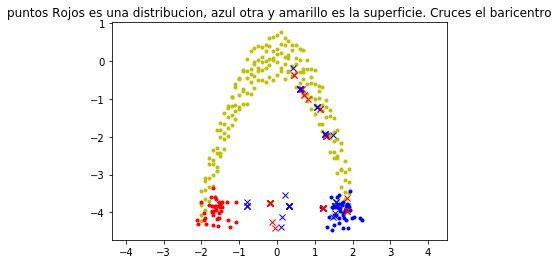

In [76]:
plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:puntos,0],y[:puntos,1],'x',c='r')
plt.plot(y[puntos:,0],y[puntos:,1],'x',c='b')
plt.axis('equal')
plt.title('puntos Rojos es una distribucion, azul otra y amarillo es la superficie. Cruces el baricentro')
plt.show()

In [260]:
#x va a ser los puntos iniciales (distintas distribuciones)
#y van a ser los transportados (baricentro)


niter=300
learningrate0=1 #TODO 
landamax=10000000 #TODO
landa0=1#TODO


#y=x
#y=10*np.ones(x.shape)

C=armar_C_categorico(z) #en z pongo fila a fila los distintos valores de z
#landa=landa0
#learningrate=learningrate0
n=0

while (n<niter):
    learningrate=min(learningrate*2.01,learningrate0)
    
    #cost,cost_grad=fermat_cost(y.flatten(),x,dimension,f_dist,tree,data,k,alpha)
    cost,cost_grad=euclidean_cost(y.flatten(),x)
    
    
    grad_matrix=grad_matrix_y(y)
    f_grad=fgrad(y,grad_matrix,C)
    
    kernel_matrix=kernel_matrix_y(y)
    
    
    beta=landa*0.4
    landamin=beta-landamin_actualizacion(cost_grad,f_grad)
    
    
    
    if(landamin>landa and landamin<landamax): 
        landa=landamin
    elif(landamin>landamax): 
        landa=landamax
    
    
    gradienteLagrangiano=lagrangiano_grad(landa,cost_grad,f_grad)
    yviejo=y
    costviejo=cost
    
    
    while(True):
        y=(yviejo.flatten()-(learningrate*gradienteLagrangiano)).reshape(yviejo.shape)  
        kernel_matrix=kernel_matrix_y(y) 
        
        #cost,cost_grad=fermat_cost(y.flatten(),x,dimension,f_dist,tree,data,k,alpha)
        cost,cost_grad=euclidean_cost(y.flatten(),x)
       
        lag_nuevo=lagrangiano(landa,kernel_matrix,C,cost)
        lag_viejo=lagrangiano(landa,kernel_matrix,C,costviejo)
        
        if(lag_nuevo<=(1+100/landa)*lag_viejo): 
            break #es que el lagrangiano nuevo disminuyo efectivamente (uso el y nuevo en ambos -kernel_matrix- pero el costo que a cada uno le corresponde)
        learningrate=learningrate/2             
      
    print("it: "+str(n)+", paso: "+str(learningrate*np.linalg.norm(gradienteLagrangiano))+", landa: "+str(landa))
    n=n+1

it: 0, paso: 5.1171875155058795e-05, landa: 2453379.139401204
it: 1, paso: 0.00010075069310670575, landa: 2453379.139401204
it: 2, paso: 0.00019418300449018533, landa: 2453379.139401204
it: 3, paso: 0.0003580829019559545, landa: 2453379.139401204
it: 4, paso: 0.0003002745056710669, landa: 2453379.139401204
it: 5, paso: 0.0005034813593298462, landa: 2453379.139401204
it: 6, paso: 0.00033843292579742294, landa: 2453379.139401204
it: 7, paso: 0.0004573949180464944, landa: 2453379.139401204
it: 8, paso: 0.0003452016177697602, landa: 2453379.139401204
it: 9, paso: 0.0003822227209942074, landa: 2453379.139401204
it: 10, paso: 0.00048101867092917907, landa: 2453379.139401204
it: 11, paso: 0.0014507802089268364, landa: 2453379.139401204
it: 12, paso: 0.00038891187104246556, landa: 2453379.139401204
it: 13, paso: 0.00025064430161409547, landa: 2453379.139401204
it: 14, paso: 0.0003265895009407668, landa: 2453379.139401204
it: 15, paso: 0.00024080362802372725, landa: 2453379.139401204
it: 16, pa

it: 131, paso: 0.0002943033887948727, landa: 3143237.899408269
it: 132, paso: 0.00023184435287796563, landa: 3143237.899408269
it: 133, paso: 0.00018254600618395435, landa: 3143237.899408269
it: 134, paso: 0.0002874685723520068, landa: 3143237.899408269
it: 135, paso: 0.00016478604124044836, landa: 3143237.899408269
it: 136, paso: 0.0001958396225445112, landa: 3143237.899408269
it: 137, paso: 0.00016410966512138704, landa: 3143237.899408269
it: 138, paso: 0.00033295910112645917, landa: 3242171.595397627
it: 139, paso: 0.0007209623139131873, landa: 3242171.595397627
it: 140, paso: 0.004023045973131727, landa: 3242171.595397627
it: 141, paso: 0.000208934386854427, landa: 3242171.595397627
it: 142, paso: 0.00019762361696774188, landa: 3242171.595397627
it: 143, paso: 0.00018686767172534306, landa: 3242171.595397627
it: 144, paso: 0.00017664262766457154, landa: 3242171.595397627
it: 145, paso: 0.00016692543363768862, landa: 3242171.595397627
it: 146, paso: 0.00015769388694184222, landa: 32

it: 261, paso: 0.00017093829206192712, landa: 3822507.9618103104
it: 262, paso: 0.0001501740878968988, landa: 3822507.9618103104
it: 263, paso: 0.00013185711043203985, landa: 3822507.9618103104
it: 264, paso: 0.00023142699910092291, landa: 3822507.9618103104
it: 265, paso: 0.00017345263291640526, landa: 3822507.9618103104
it: 266, paso: 0.0002601376486370987, landa: 3822507.9618103104
it: 267, paso: 0.0002612122041027802, landa: 3822507.9618103104
it: 268, paso: 0.00015911886029101028, landa: 3899037.0197198796
it: 269, paso: 0.00031999653610848336, landa: 3899037.0197198796
it: 270, paso: 0.0006937469014123164, landa: 3899037.0197198796
it: 271, paso: 0.00013779878459796257, landa: 3899037.0197198796
it: 272, paso: 0.0001458692644500674, landa: 3899037.0197198796
it: 273, paso: 0.0001637207860595804, landa: 3953892.7213976476
it: 274, paso: 0.00032983327669170923, landa: 3953892.7213976476
it: 275, paso: 0.0007351485128716522, landa: 3953892.7213976476
it: 276, paso: 0.000172501502667

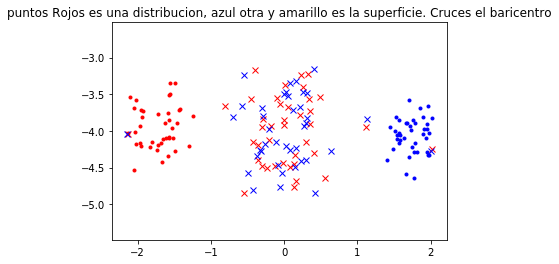

In [261]:
#plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:puntos,0],y[:puntos,1],'x',c='r')
plt.plot(y[puntos:,0],y[puntos:,1],'x',c='b')
plt.axis('equal')
plt.title('puntos Rojos es una distribucion, azul otra y amarillo es la superficie. Cruces el baricentro')
plt.show()

# Pruebas que anduvieron bien!

## Aca use y=x como inicial, beta=landa*0.5, lag_nuevo<=(1+1/landa)*lag_viejo, niter=30000, learningrate0=1,beta=1 inicial, landamax=10e4, landa0=10

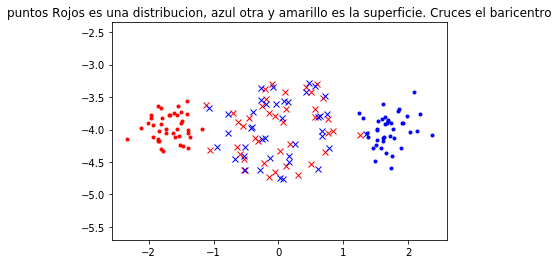

In [12]:
#plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:puntos,0],y[:puntos,1],'x',c='r')
plt.plot(y[puntos:,0],y[puntos:,1],'x',c='b')
plt.axis('equal')
plt.title('puntos Rojos es una distribucion, azul otra y amarillo es la superficie. Cruces el baricentro')
plt.show()

## Aca use y=x como inicial, beta=landa*0.4, lag_nuevo<=(1+0.01/landa)*lag_viejo, niter=100000, learningrate0=1,beta=1 inicial, landamax=10e4, landa0=10

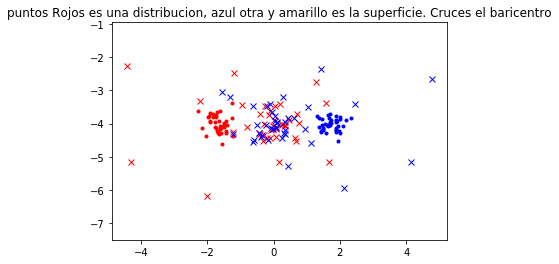

In [554]:
#plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:puntos,0],y[:puntos,1],'x',c='r')
plt.plot(y[puntos:,0],y[puntos:,1],'x',c='b')
plt.axis('equal')
plt.title('puntos Rojos es una distribucion, azul otra y amarillo es la superficie. Cruces el baricentro')
plt.show()

Probando un poco que ande le algoritmo y descienda bien la parte de la f

[ 0.00078002  0.          0.00079181  0.         -0.00079181  0.
 -0.00078002  0.        ]


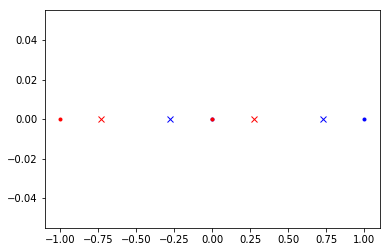

In [118]:
yy=np.array([[1,0],[0,0],[0,0],[-1,0]])
yy_init=yy
zz=np.array([1,1,2,2]).T

for i in range(500):
    C2=armar_C_categorico(zz)
    grad_matrix2=grad_matrix_y(yy)
    f_grad=fgrad(yy,grad_matrix2,C2)
    if (i==0): print(f_grad)

    yy=yy.flatten()-f_grad
    yy=yy.reshape(-1,2)

plt.plot(yy_init[:2,0],yy_init[:2,1],'.',c='b')
plt.plot(yy_init[2:,0],yy_init[2:,1],'.',c='r')
plt.plot(yy[:2,0],yy[:2,1],'x',c='b')
plt.plot(yy[2:,0],yy[2:,1],'x',c='r')
plt.show()
    

# Ignorar, son cosas viejas o pruebas tontas  de aca para abajo

esto dio con 10.000 iteraciones

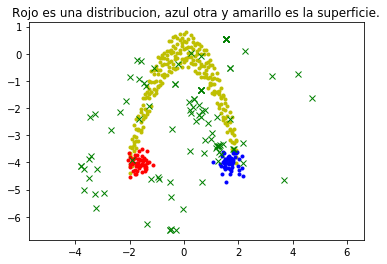

In [67]:
plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:,0],y[:,1],'x',c='g')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie.')
plt.show()

Esto dio con 500 iteraciones, va queriendo...

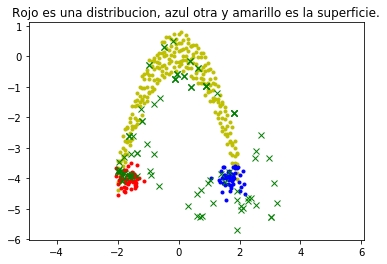

In [64]:
plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:,0],y[:,1],'x',c='g')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie.')
plt.show()

In [68]:
hice10000=y

In [154]:
def kernel_matrix_y(y):
    def fu(i,j):
        return kernel(y[i,:],y[j,:])
    f=np.vectorize(fu)
    return np.fromfunction(f,(y.shape[0],y.shape[0]),dtype=int)  
    
    
def grad_matrix_y(y):
    def fu2(i,j,d):
        return kernel_grad(y[i,:],y[j,:])[d]
    f2=np.vectorize(fu2)
    return np.fromfunction(f2,(y.shape[0],y.shape[0],dimension),dtype=int)  